In [13]:
#in this code, we modify the NN input at the begining of each new step block os period=Tbatch
import os
%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL']="2"
import numpy as np # linear algebra
from pyvis.network import Network
import networkx as nx
from numpy import save
from numpy import load
import random
from numpy import newaxis
from numpy import array
from numpy import array
import torch
torch.manual_seed(0)
from torch import nn
torch.pi = torch.acos(torch.zeros(1)).item() * 2 # which is 3.1415927410125732  
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
import array
from sklearn.metrics import confusion_matrix 
plt.style.use('seaborn-whitegrid')
print ('import completed')

import completed


In [5]:
torch.autograd.set_detect_anomaly(True)
#initializing the power time and distance
global N
global t
global Time_res
global Tnode
global TimeOfFlight_Matrix
N=16
tt_analytical=2800 #NUMBER OF CONSIDERED TIME INDICES
Tbatch=10 
t=torch.zeros((N,TT))
Tx_powers=1.995*np.ones((N,1), dtype=int)
N_height=1.5
AttExp = 4             # Attenuation Exponent (4 = 2-RAY MODEL)
AttConst = 1000**2       # Attenuation coefficient (e.g., Aeff)
X_max=10
Y_max=10
Time_res=torch.tensor(1/200)
p_0=3.9811 * (10**(-15)) # Threshold power
C = 3*(10**8);                 # speed of light in meters/second
Eps0=1

In [14]:
location_X_analytic=load('mycoordinateX.npy') #X Co-ordinates of all the nodes

location_Y_analytic=load('mycoordinateY.npy') #Y Co-ordinates of al the nodes

#Allocating the different node distance randomly
Distance_matrix_analytic=np.zeros((N,N))
for i in range(N):
    for j in range(i+1, N):
        Distance_matrix_analytic[i,j]=1000*np.sqrt(np.square(location_X_analytic[j]-location_X_analytic[i])+np.square(location_Y_analytic[j]-location_Y_analytic[i]))
        Distance_matrix_analytic[j,i]=Distance_matrix_analytic[i,j]

#Evaluating the time of flight across different node distances 
TimeOfFlight_Matrix_analytic = np.zeros((N,N))
for ii in range (N):
    for jj in range (N):
        TimeOfFlight_Matrix_analytic[ii,jj]=Distance_matrix_analytic[ii,jj]/C
        #TimeOfFlight_Matrix_analytic[jj,ii]=TimeOfFlight_Matrix_analytic[ii,jj]
        
#Generating power RSSI matrix, i.e. Pr
#Row index = receiver, Column index = transmitter
RSSI_Matrix_analytic = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if i != j :     # If ii=jj the RSSI is infinite
            RSSI_Matrix_analytic[i,j] = (Tx_powers[j]*N_height**2)/(Distance_matrix_analytic[i,j]**AttExp)
            if RSSI_Matrix_analytic[i,j]<p_0:
                RSSI_Matrix_analytic[i,j]=0
        elif i == j:
            RSSI_Matrix_analytic[i,j] = 0
            
Tnode=load('myNodePeriod.npy')

inittimenumpy=load('myinitial_time.npy')

t[:,0]=torch.tensor(inittimenumpy)

Text(0, 0.5, 'y-coordinate')

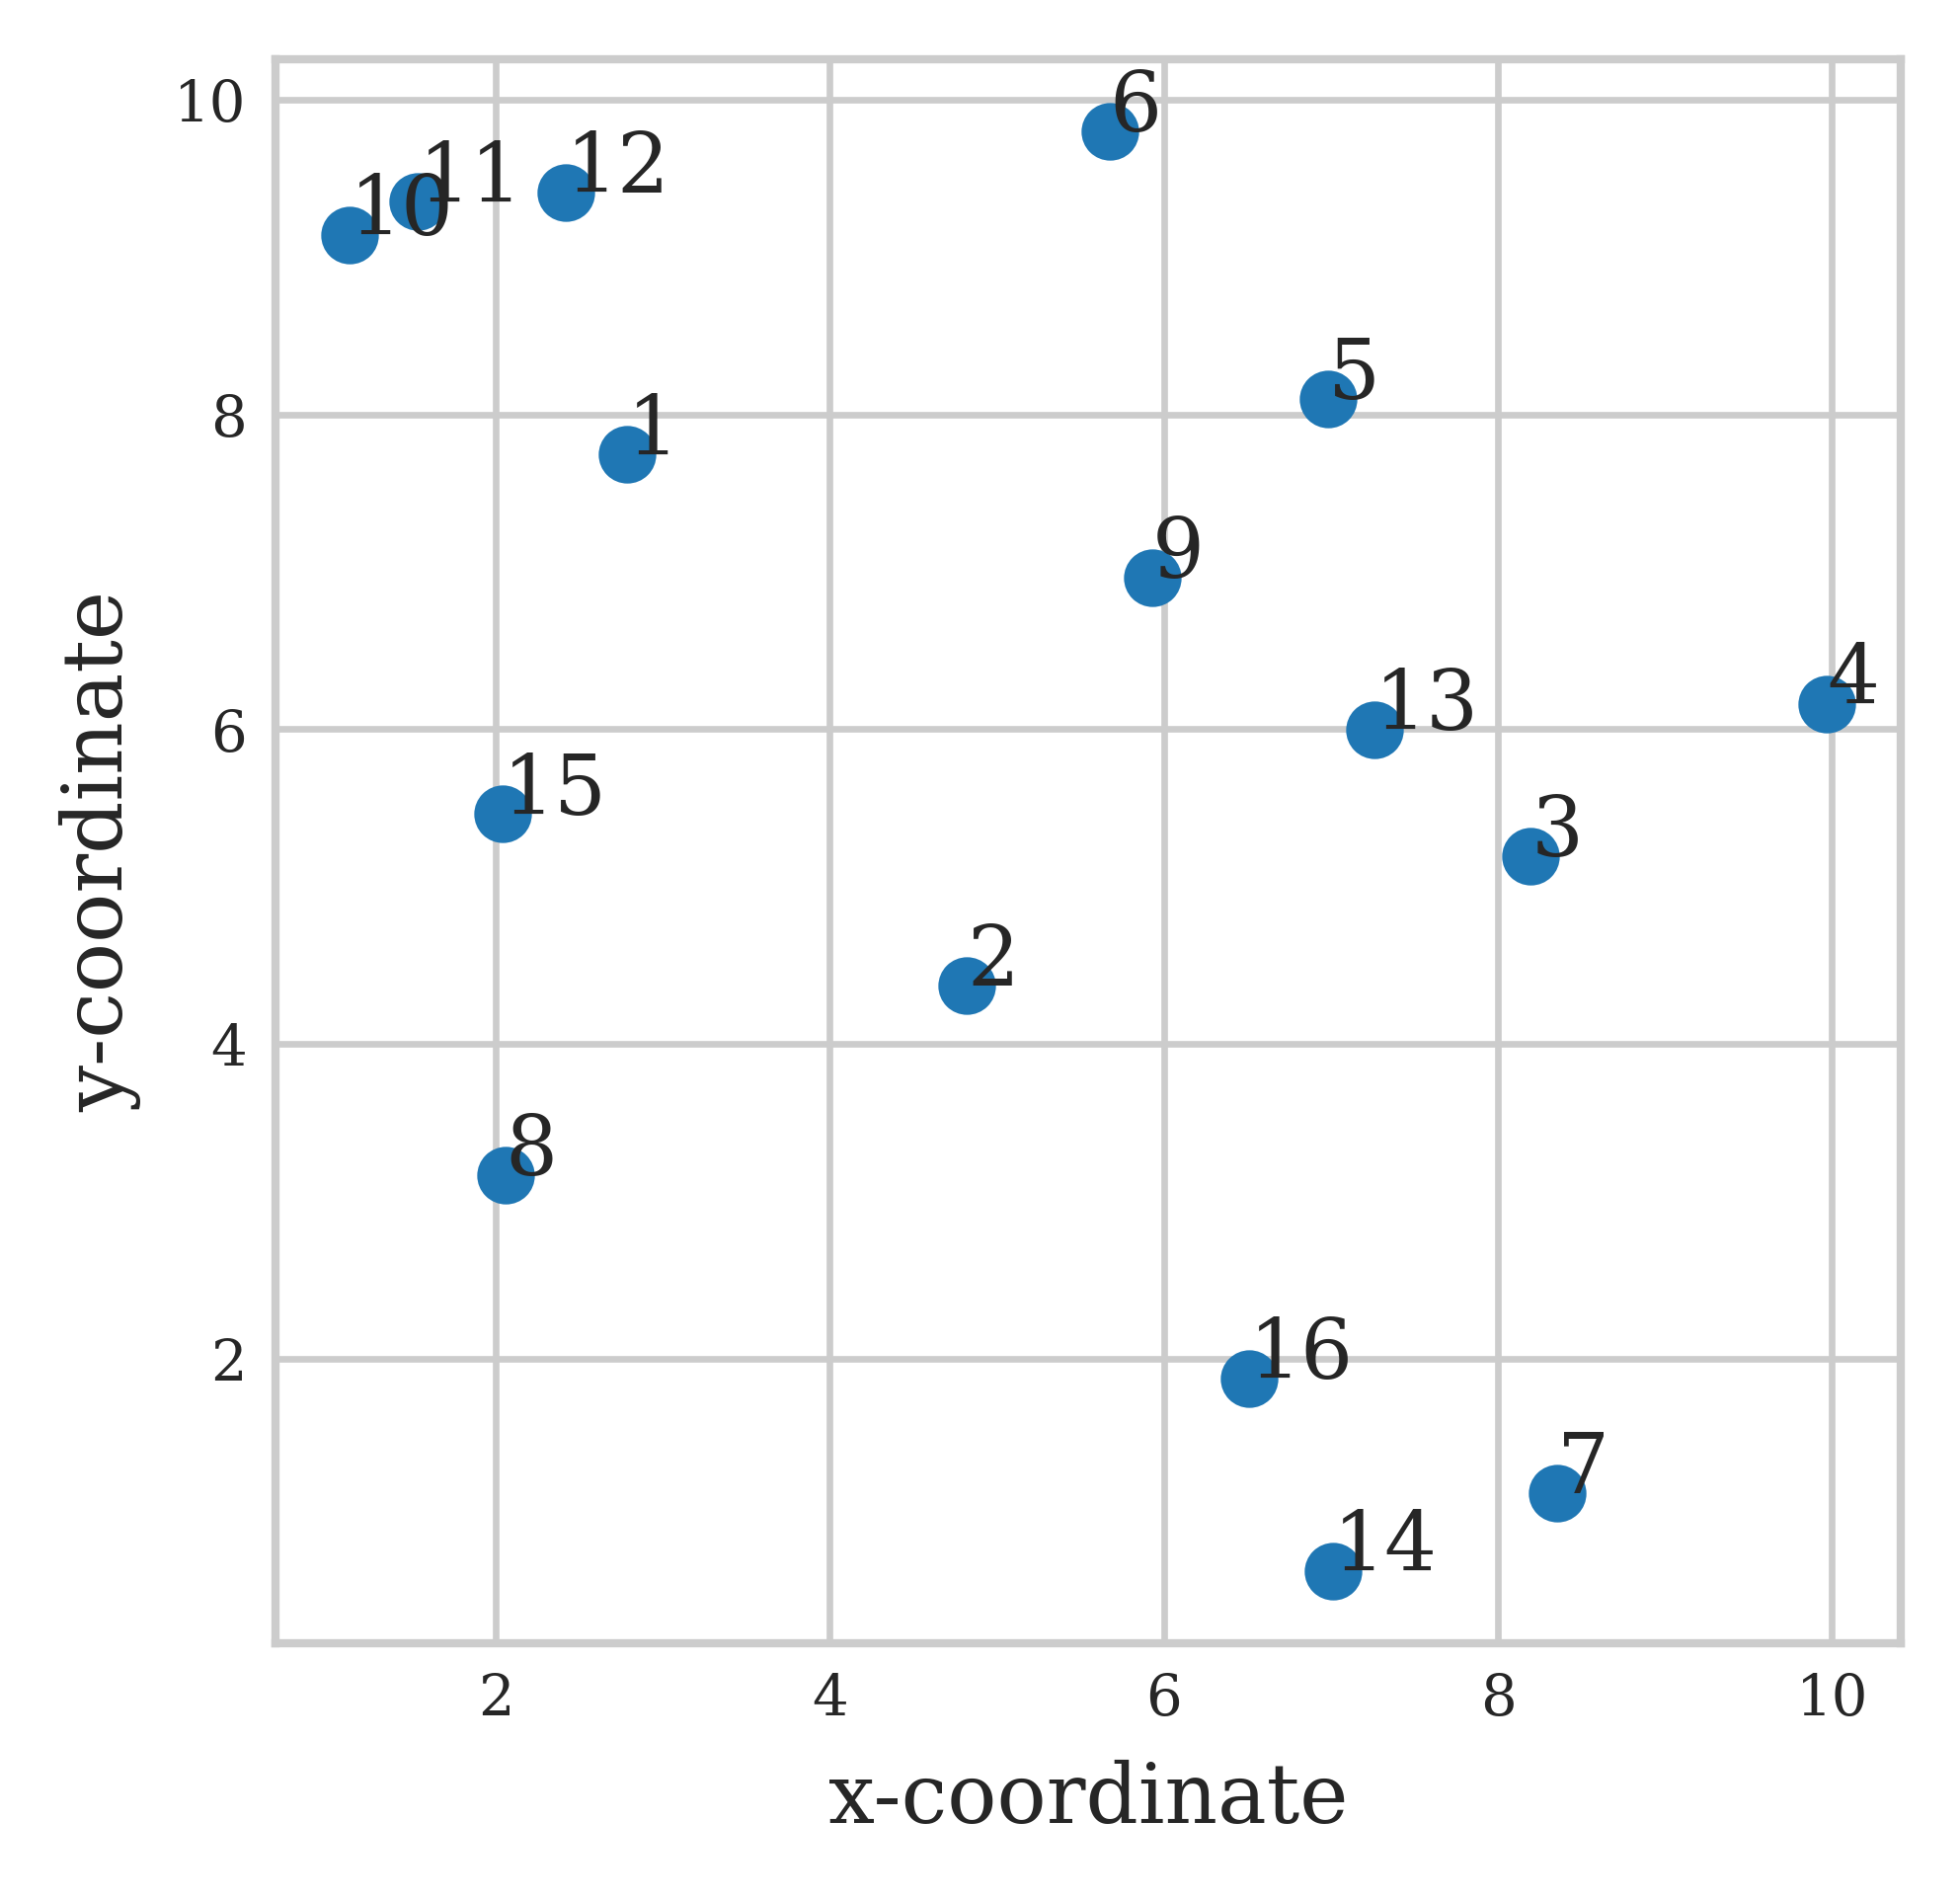

In [15]:
#Generating adjacent matrix of the classical model
Adj_Matrix=np.zeros((N,N))
for ii in range (N):
        for jj in range (N):
            Adj_Matrix[ii,jj] = RSSI_Matrix_analytic[ii,jj]/np.sum(RSSI_Matrix_analytic[ii,:])

t_analytic=np.zeros((N,tt_analytical), dtype=float)
t_analytic[:,0]= t[:,0].detach().numpy()
    
#SCATTER PLOT OF NETWORK NODE CONFIGURATION
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')

plt.rc('ytick', labelsize='x-small')
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)
plt.scatter(location_X_analytic, location_Y_analytic, label='WSN Layout', marker='o')
for index in range(N):
    plt.text(x=location_X_analytic[index],y=location_Y_analytic[index], s= index+1)
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')


In [16]:
#Generate clock phases
TxPattern = np.random.randint(N,size=tt_analytical)
timeCNT=0   #Discrete-time index
number_superframes=1

#  Start simulation d
for Counter200 in range(number_superframes): # Counts frames of length 1 sec
        for frame_index in range(tt_analytical):
            timeCNT = timeCNT+1      #Current global time
            UserTxNow = TxPattern[frame_index]  #This is the tranmsitter which sends this time
            for UserIndex in range(N):         # update clocks of all nodes (using Eqn. (16))
                if timeCNT<= tt_analytical-1:
                    weight= np.dot(Adj_Matrix[UserIndex,:],TimeOfFlight_Matrix_analytic[:,UserIndex])+ np.dot(Adj_Matrix[UserIndex,:],(t_analytic[:,timeCNT-1]-t_analytic[UserIndex,timeCNT-1])) # when we consider propagation delay
                    t_analytic[UserIndex,timeCNT] = t_analytic[UserIndex,timeCNT-1] + Tnode[UserIndex] + Eps0*weight


period is 0.0050020814
 SD of Period at 2799 5.47152e-07


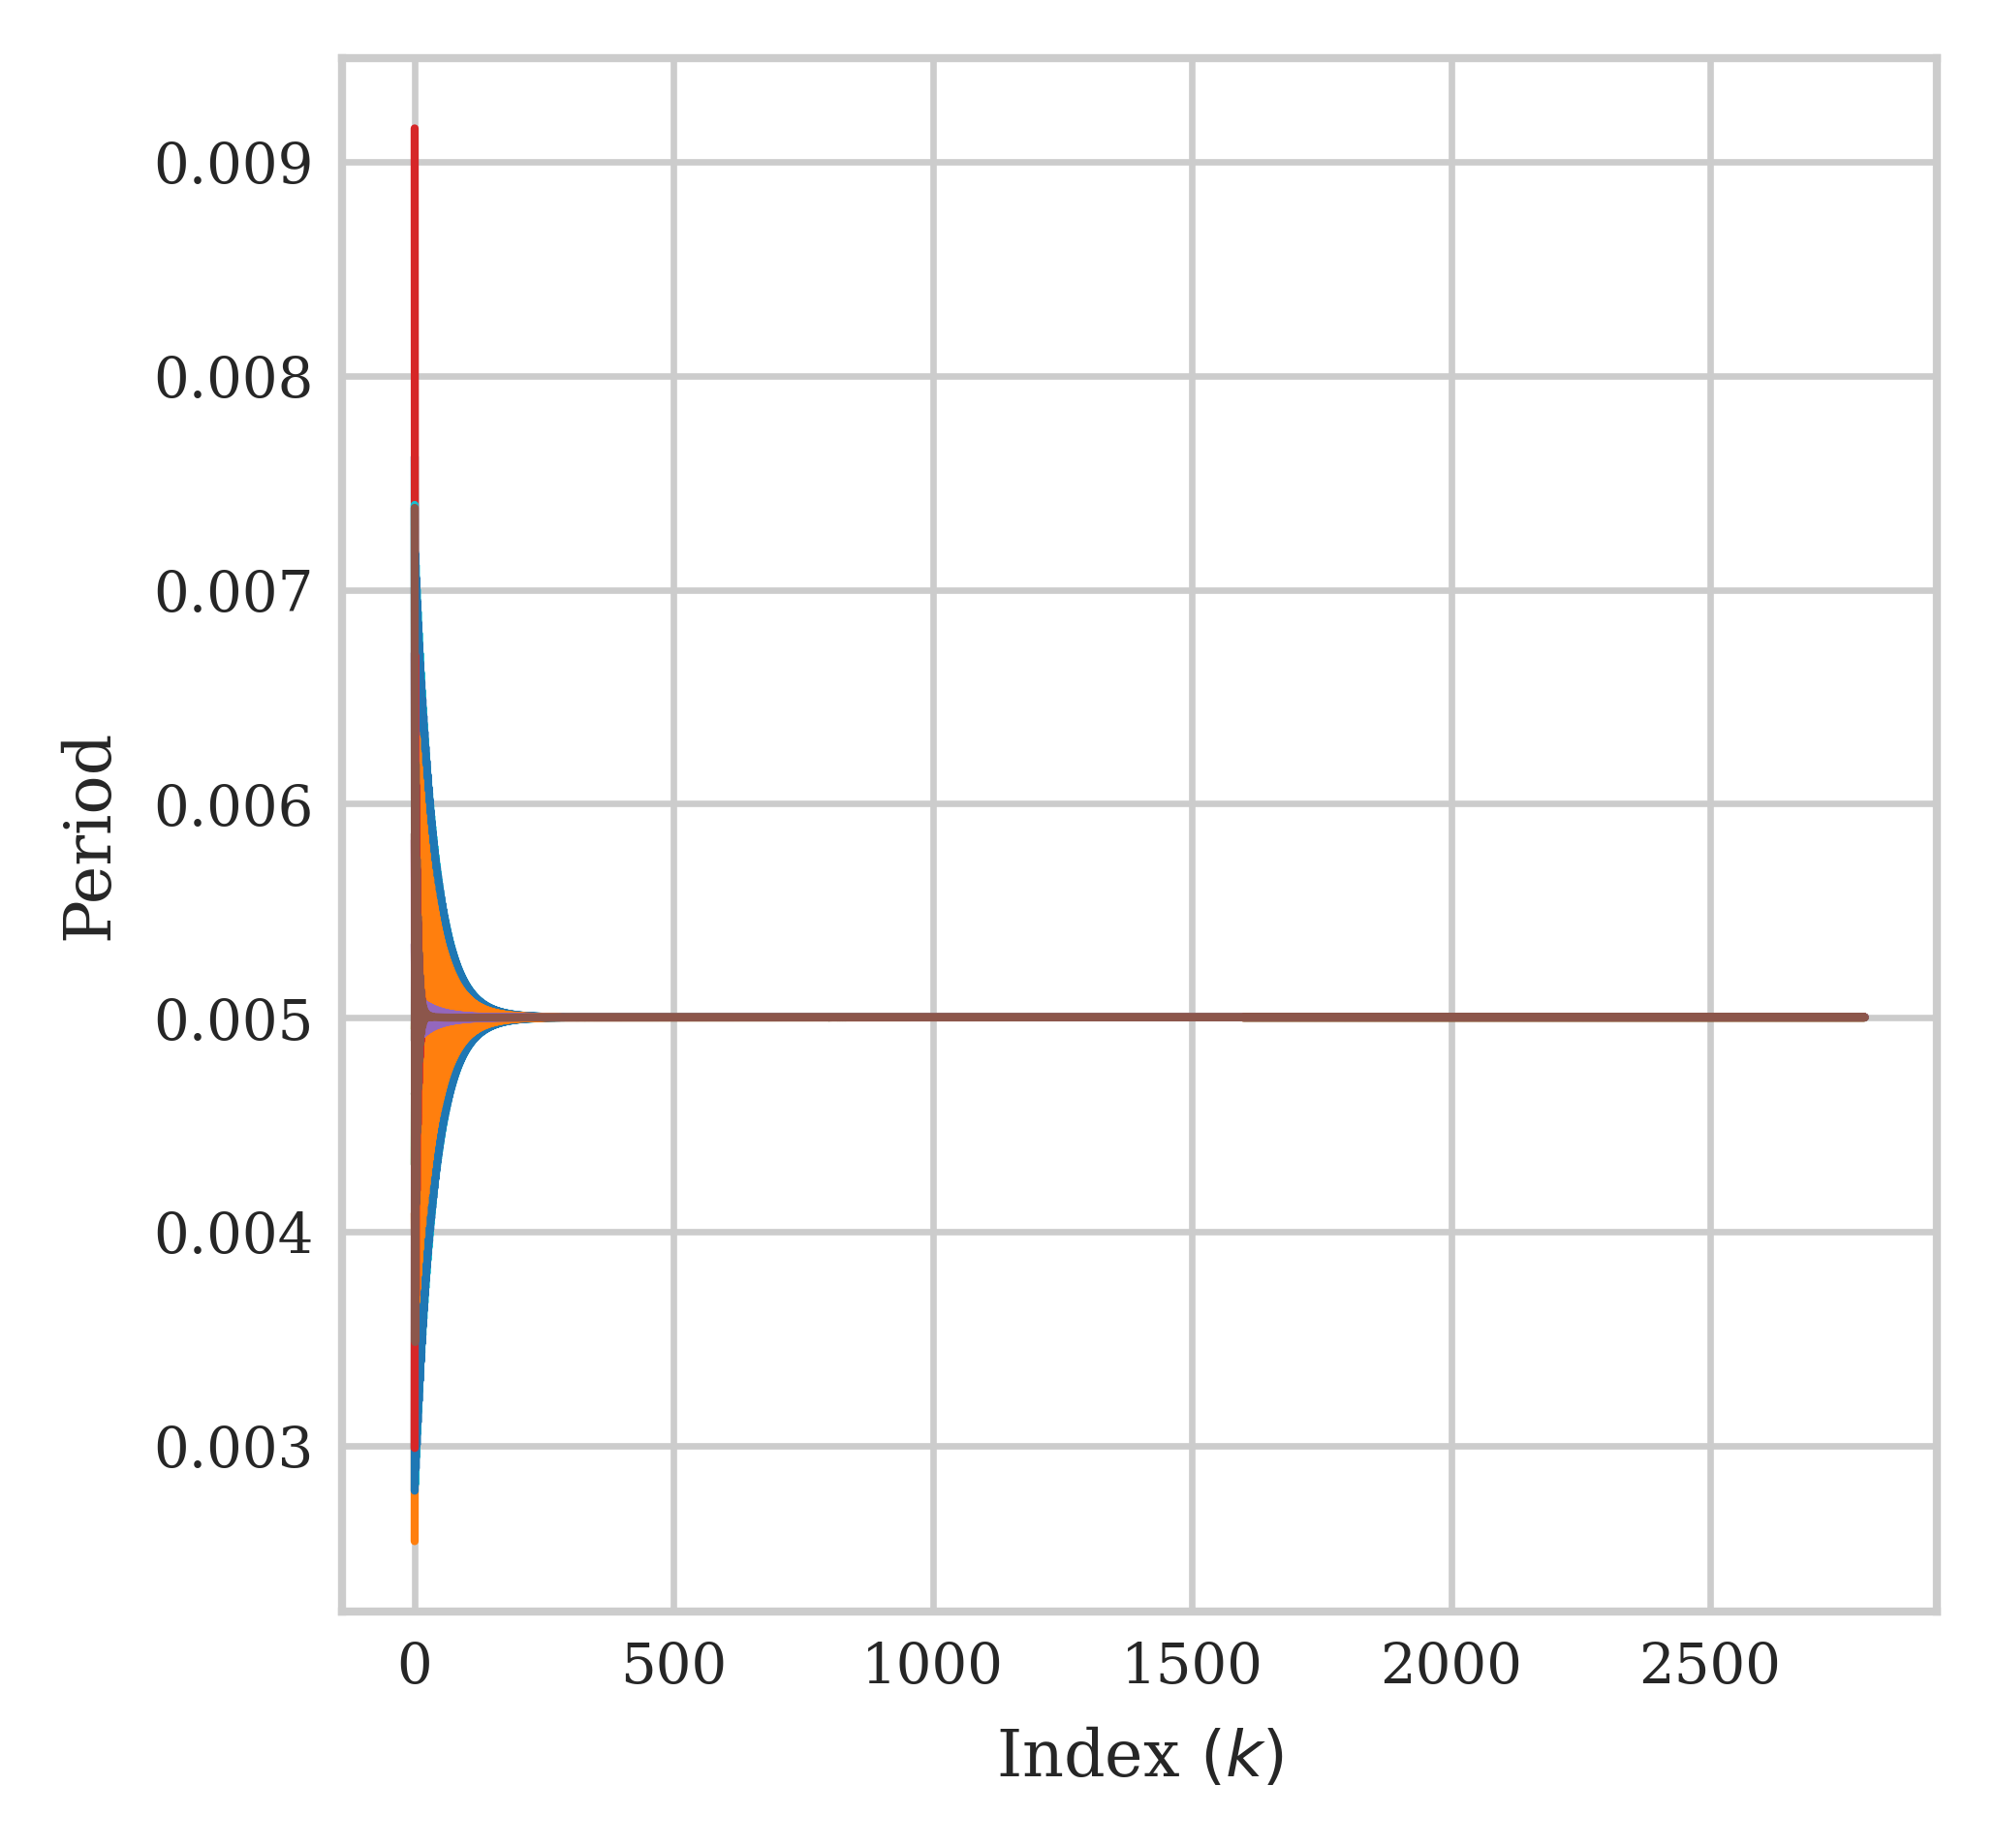

In [17]:
# PLOT PERIOD ACROSS NODES
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)
period_analytic=torch.zeros(N,tt_analytical-1)
per_var_analytic=torch.zeros(tt_analytical-1)
per_mean_analytic=torch.zeros(tt_analytical-1)
for ind in range(tt_analytical-1):
    for i in range(N):
        period_analytic[i,ind]=t_analytic[i,ind+1]-t_analytic[i,ind]
    per_var_analytic[ind]=torch.var(period_analytic[:,ind])


for node in range(N):
    plt.plot(range(0,tt_analytical-1),(period_analytic[node,0:tt_analytical-1]), linewidth=1)
plt.xlabel('Index $(k)$', fontsize=8)
plt.ylabel('Period', fontsize=8)


per_mean_analytic=torch.mean(period_analytic[:,tt_analytical-2])
print("period is", per_mean_analytic.detach().numpy())

#MEAN OF THE VARIANCE NORMALIZED TO THE CLOCK
mean_per_var_analytic=torch.mean(per_var_analytic)/Time_res
print(' SD of Period at 2799', torch.sqrt(per_var_analytic[2798]).detach().numpy())

tensor([[1.7011e-04, 2.7893e-03, 2.4903e-03,  ..., 2.1307e-03, 2.1306e-03,
         2.1306e-03],
        [4.7212e-03, 2.2736e-03, 2.8508e-03,  ..., 2.3252e-03, 2.3252e-03,
         2.3251e-03],
        [4.4009e-03, 3.7133e-03, 3.8871e-03,  ..., 2.3519e-03, 2.3528e-03,
         2.3518e-03],
        ...,
        [3.4348e-03, 1.4224e-03, 3.1138e-03,  ..., 2.4320e-03, 2.4310e-03,
         2.4319e-03],
        [2.5662e-05, 1.7268e-03, 2.1814e-03,  ..., 2.2213e-03, 2.2212e-03,
         2.2212e-03],
        [8.7826e-04, 3.2588e-03, 1.7414e-03,  ..., 2.4282e-03, 2.4291e-03,
         2.4281e-03]], dtype=torch.float64)

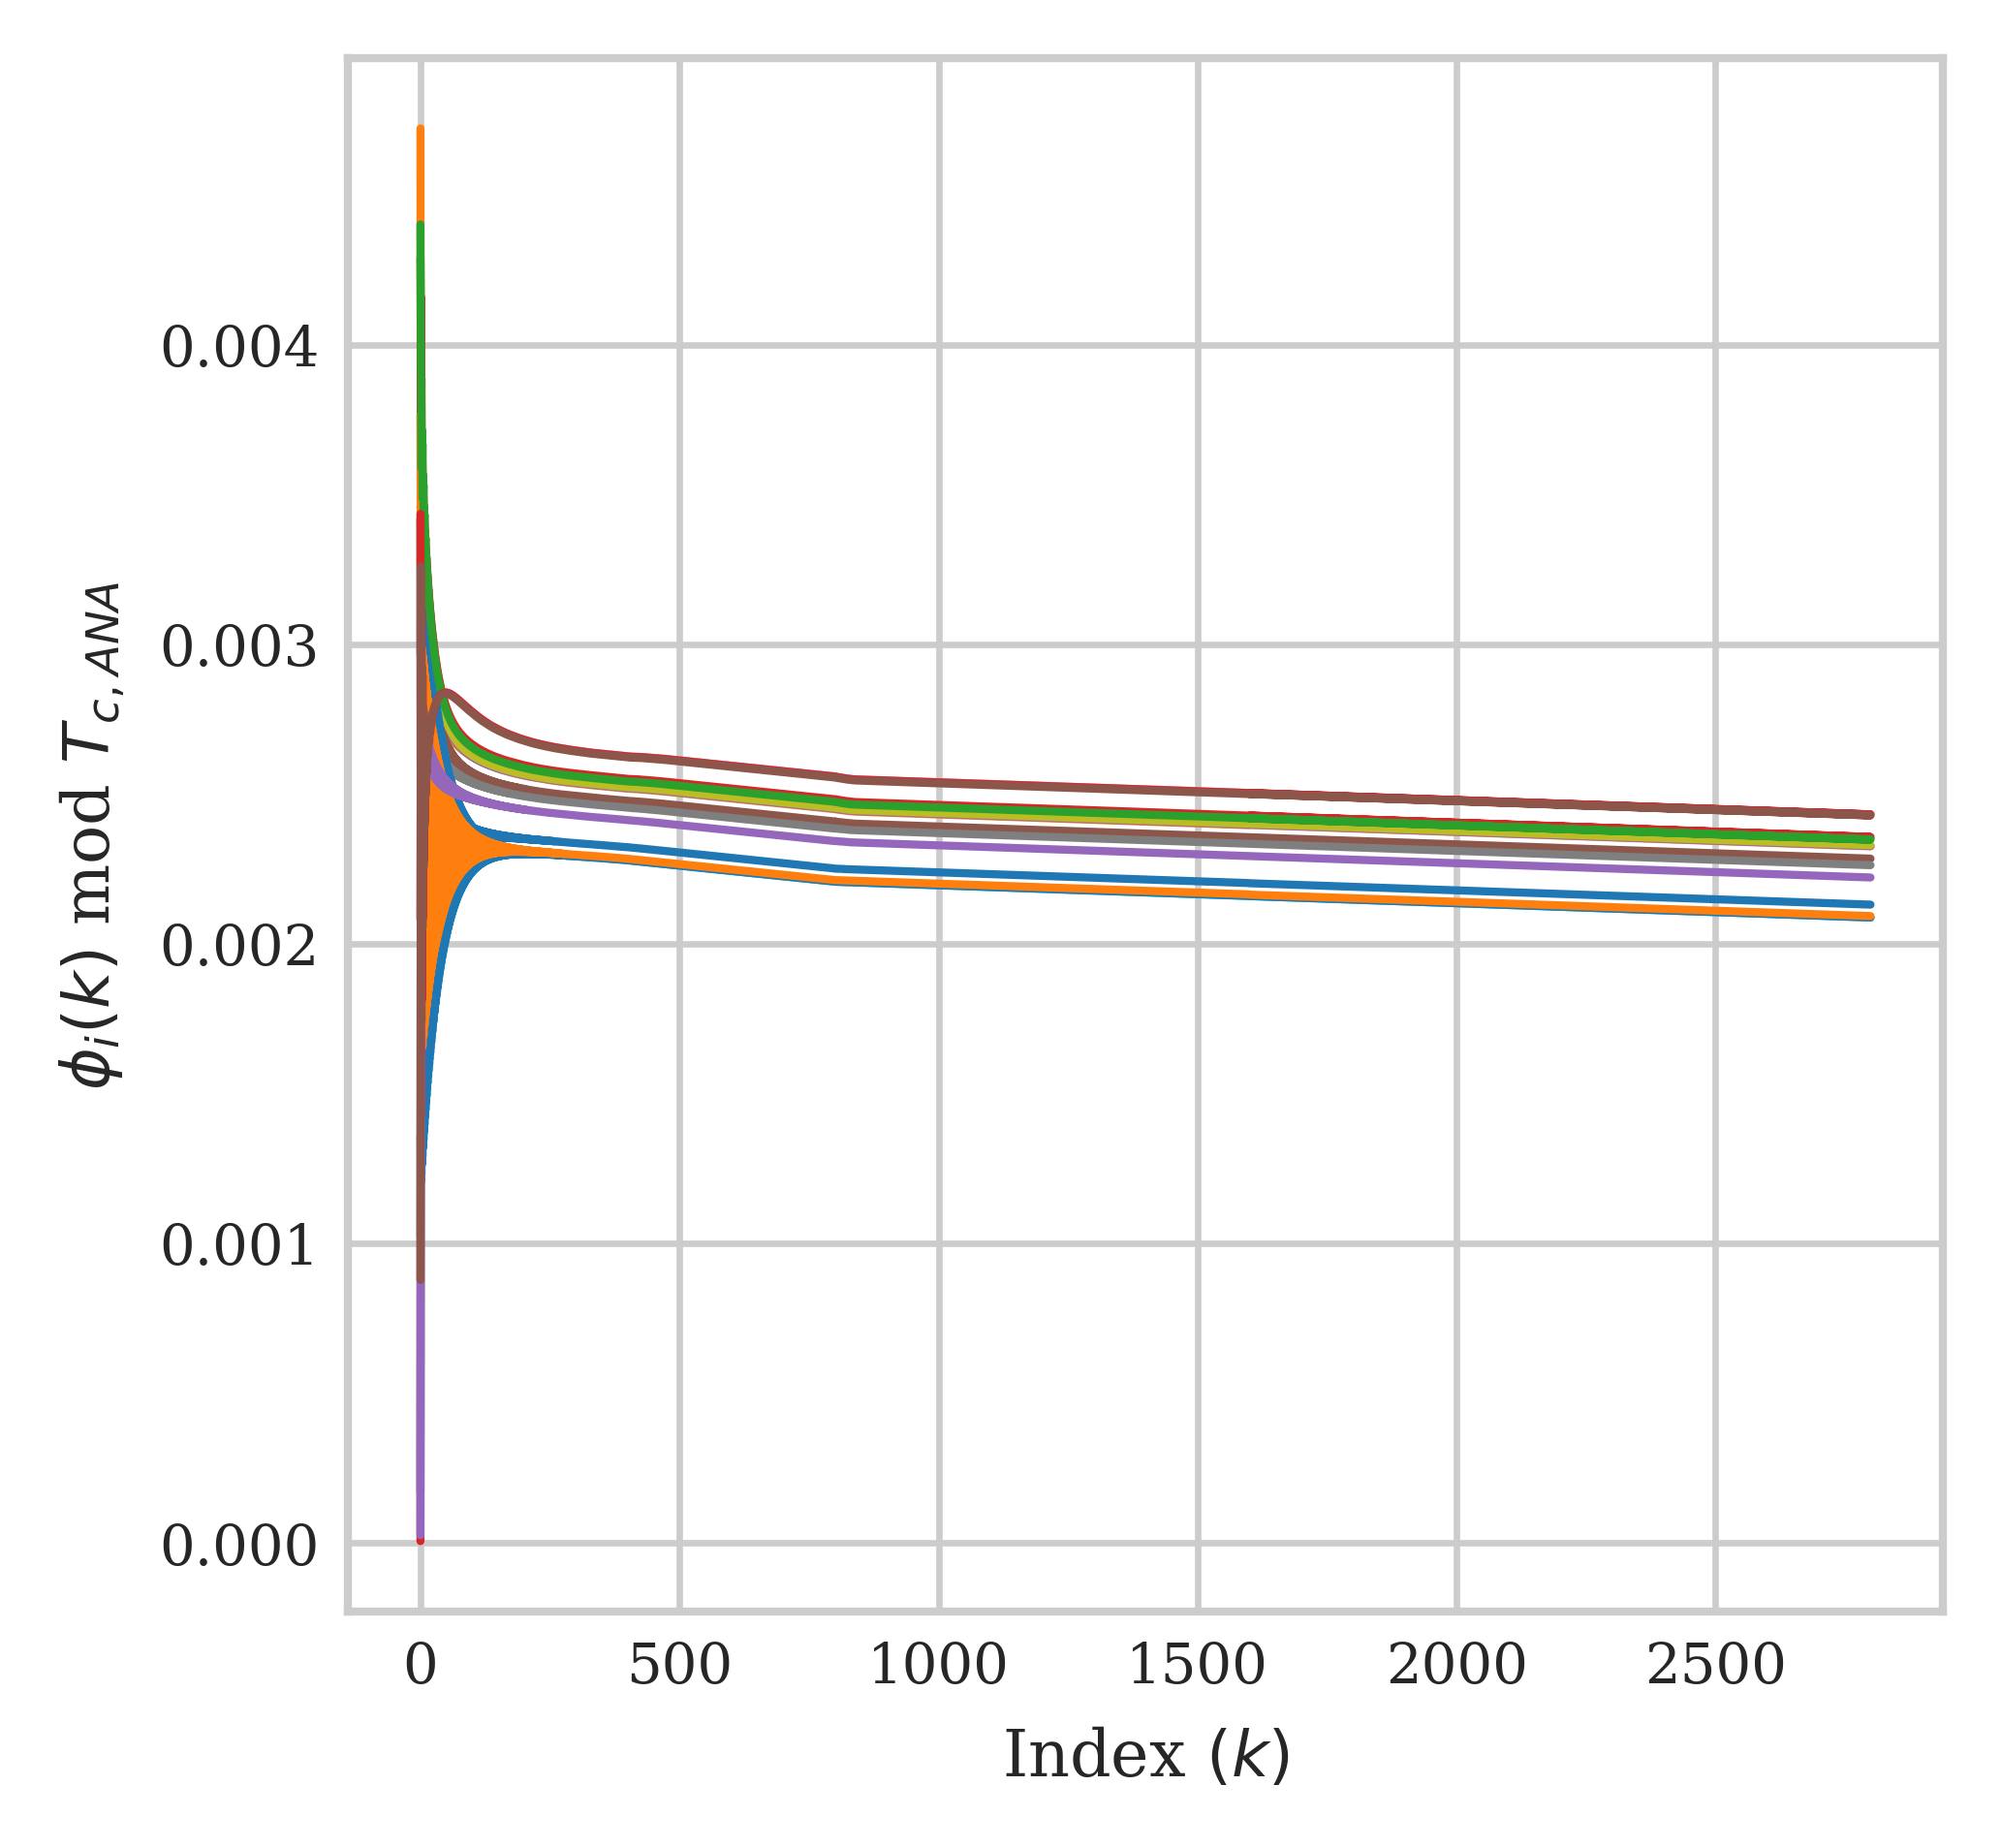

In [18]:
# PLOT MODULUS WRT PERIOD
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)
modulo_analytic=torch.tensor(t_analytic)%per_mean_analytic
for node in range(N):
    plt.plot(modulo_analytic[node,:], linewidth=1)
plt.xlabel('Index $(k)$', fontsize=8)
plt.ylabel('$\phi_i(k)$ mod $T_{c,ANA}$', fontsize=8)

modulo_analytic

Text(0, 0.5, '$\\phi_i(k)$ mod $T_c$')

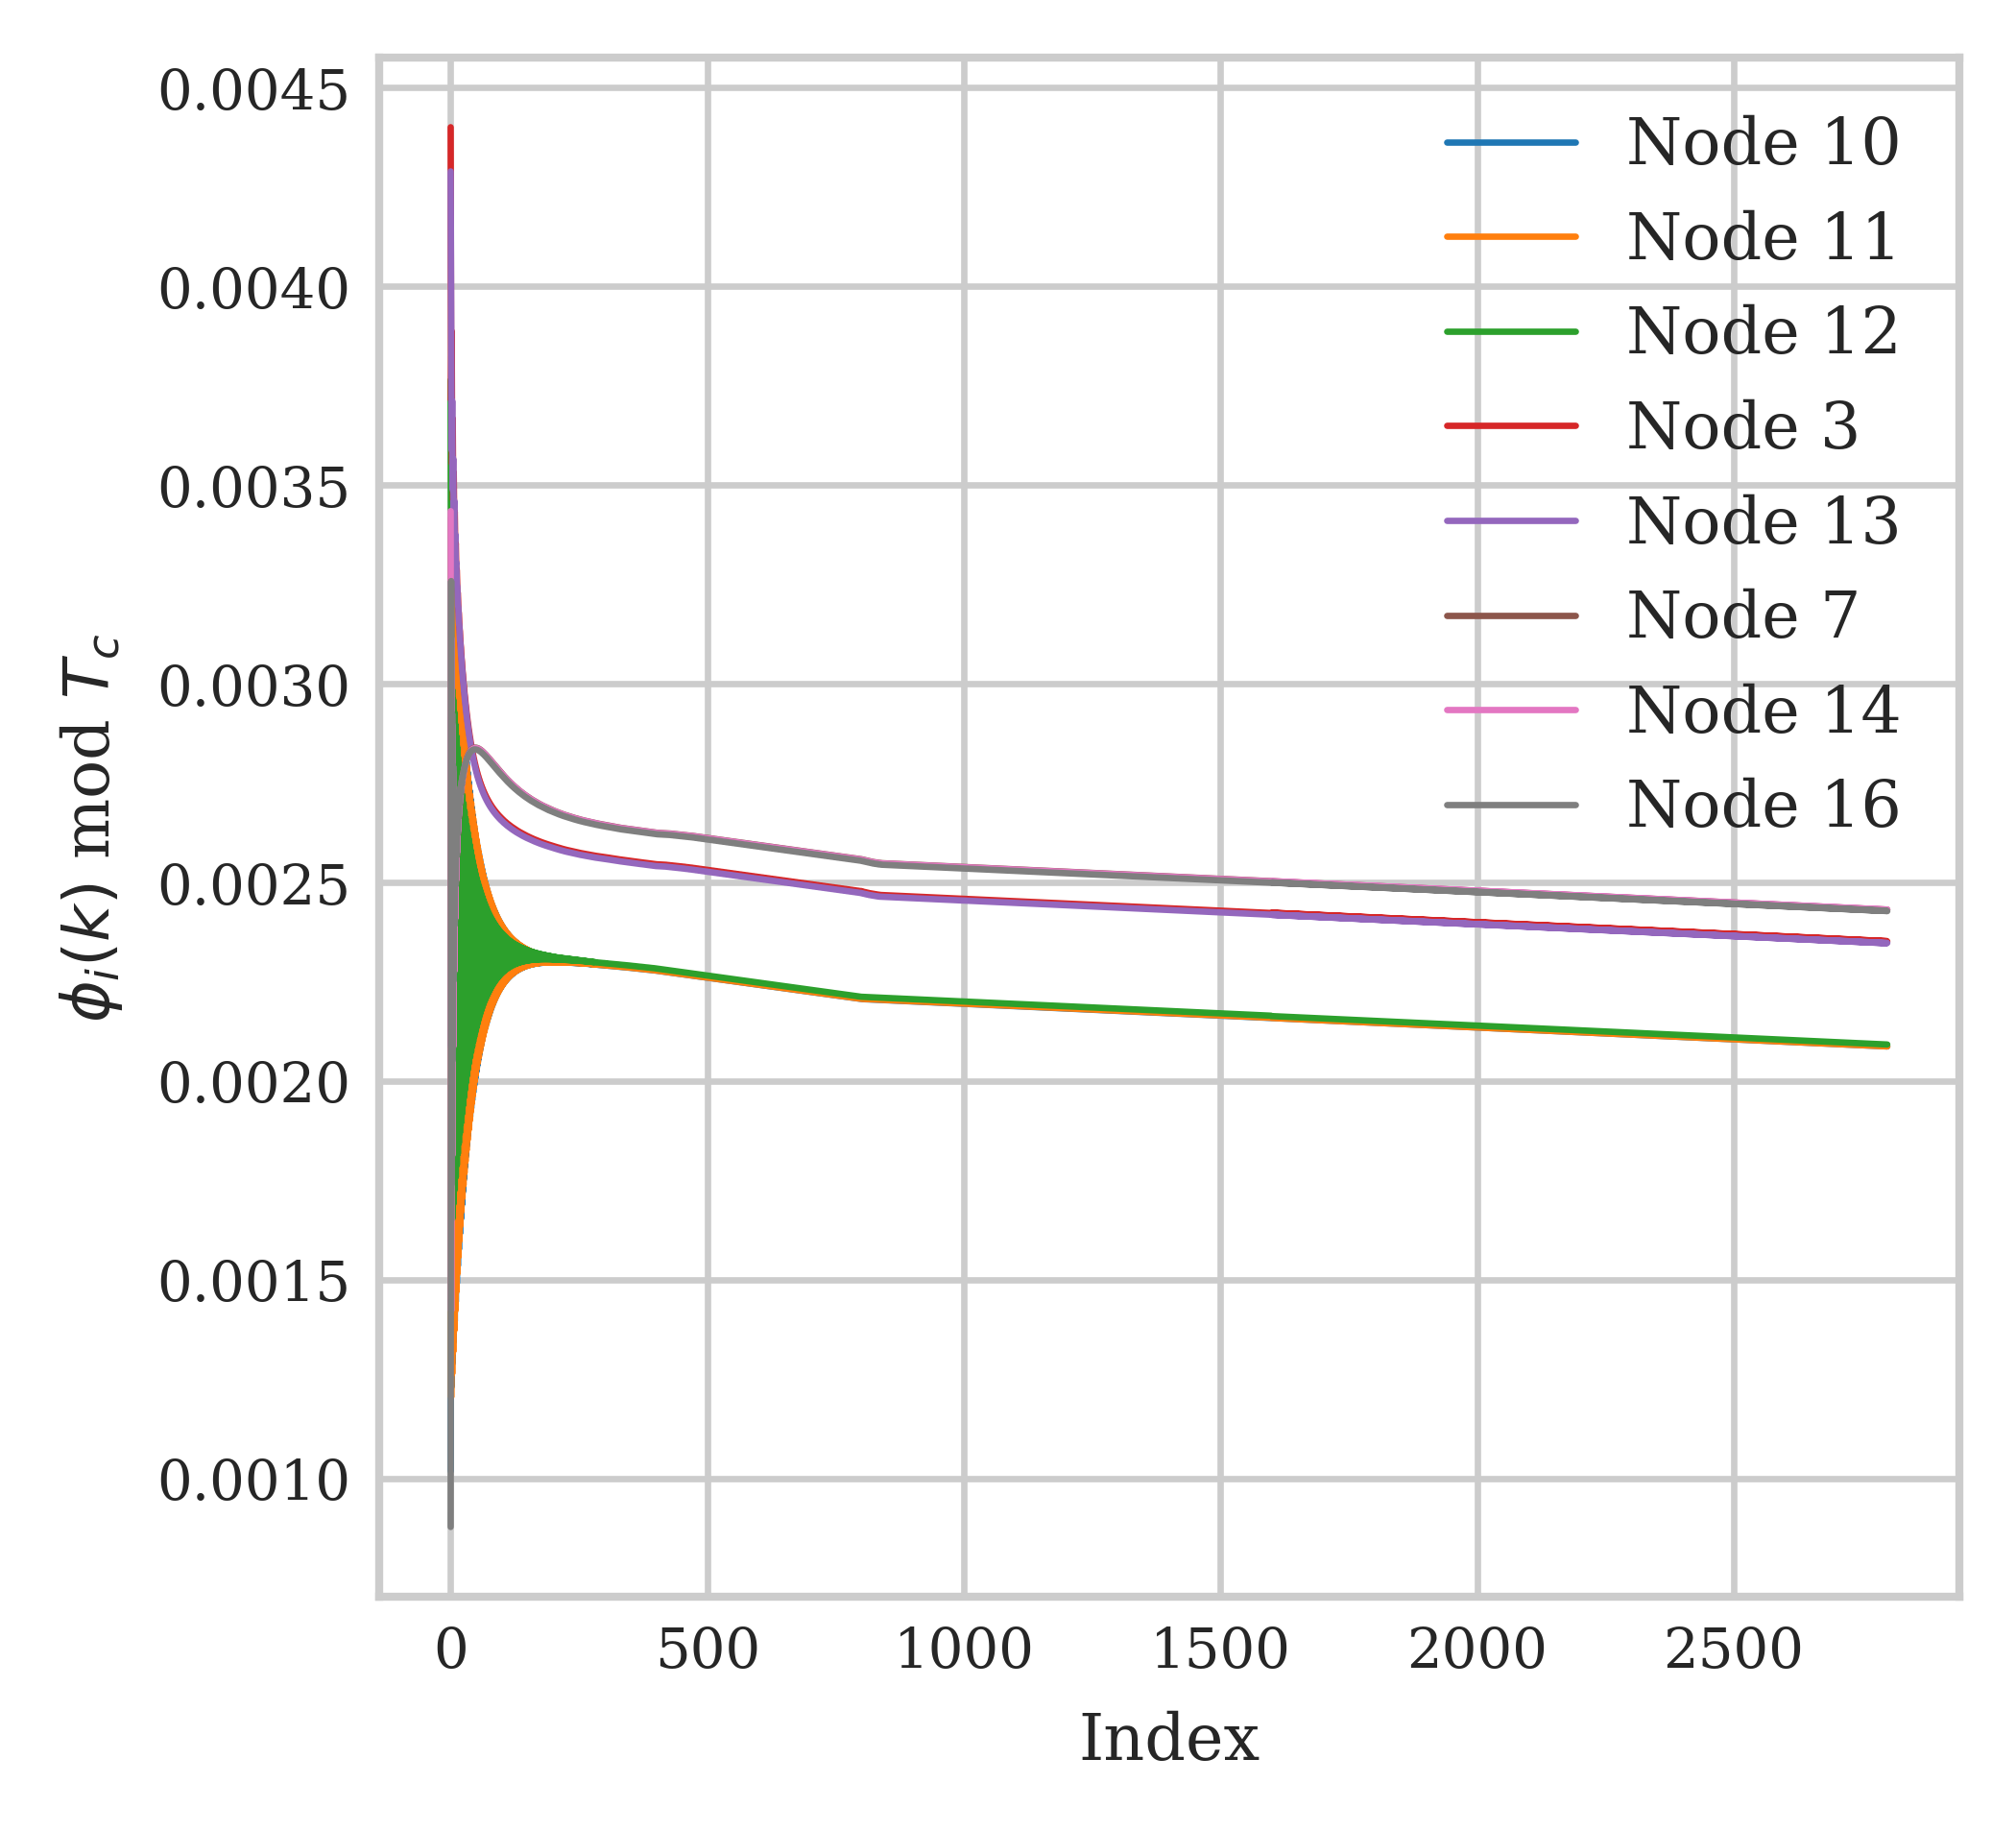

In [19]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)
plt.plot(range(tt_analytical),modulo_analytic[9,:], linewidth=0.8,label="Node 10")
plt.plot(range(tt_analytical),modulo_analytic[10,:], linewidth=0.8,label="Node 11")
plt.plot(range(tt_analytical),modulo_analytic[11,:], linewidth=0.8,label="Node 12")
plt.plot(range(tt_analytical),modulo_analytic[2,:], linewidth=0.8,label="Node 3")
plt.plot(range(tt_analytical),modulo_analytic[12,:], linewidth=0.8,label="Node 13")
plt.plot(range(tt_analytical),modulo_analytic[6,:], linewidth=0.8,label="Node 7")
plt.plot(range(tt_analytical),modulo_analytic[13,:], linewidth=0.8,label="Node 14")
plt.plot(range(tt_analytical),modulo_analytic[15,:], linewidth=0.8,label="Node 16")

plt.legend(loc="upper right",fontsize='8')
plt.xlabel('Index',fontsize='8')
plt.ylabel('$\phi_i(k)$ mod $T_c$',fontsize='8')

mean_norm_delay= 0.030052073241677135
STD_norm_delay= 0.02373870324643376


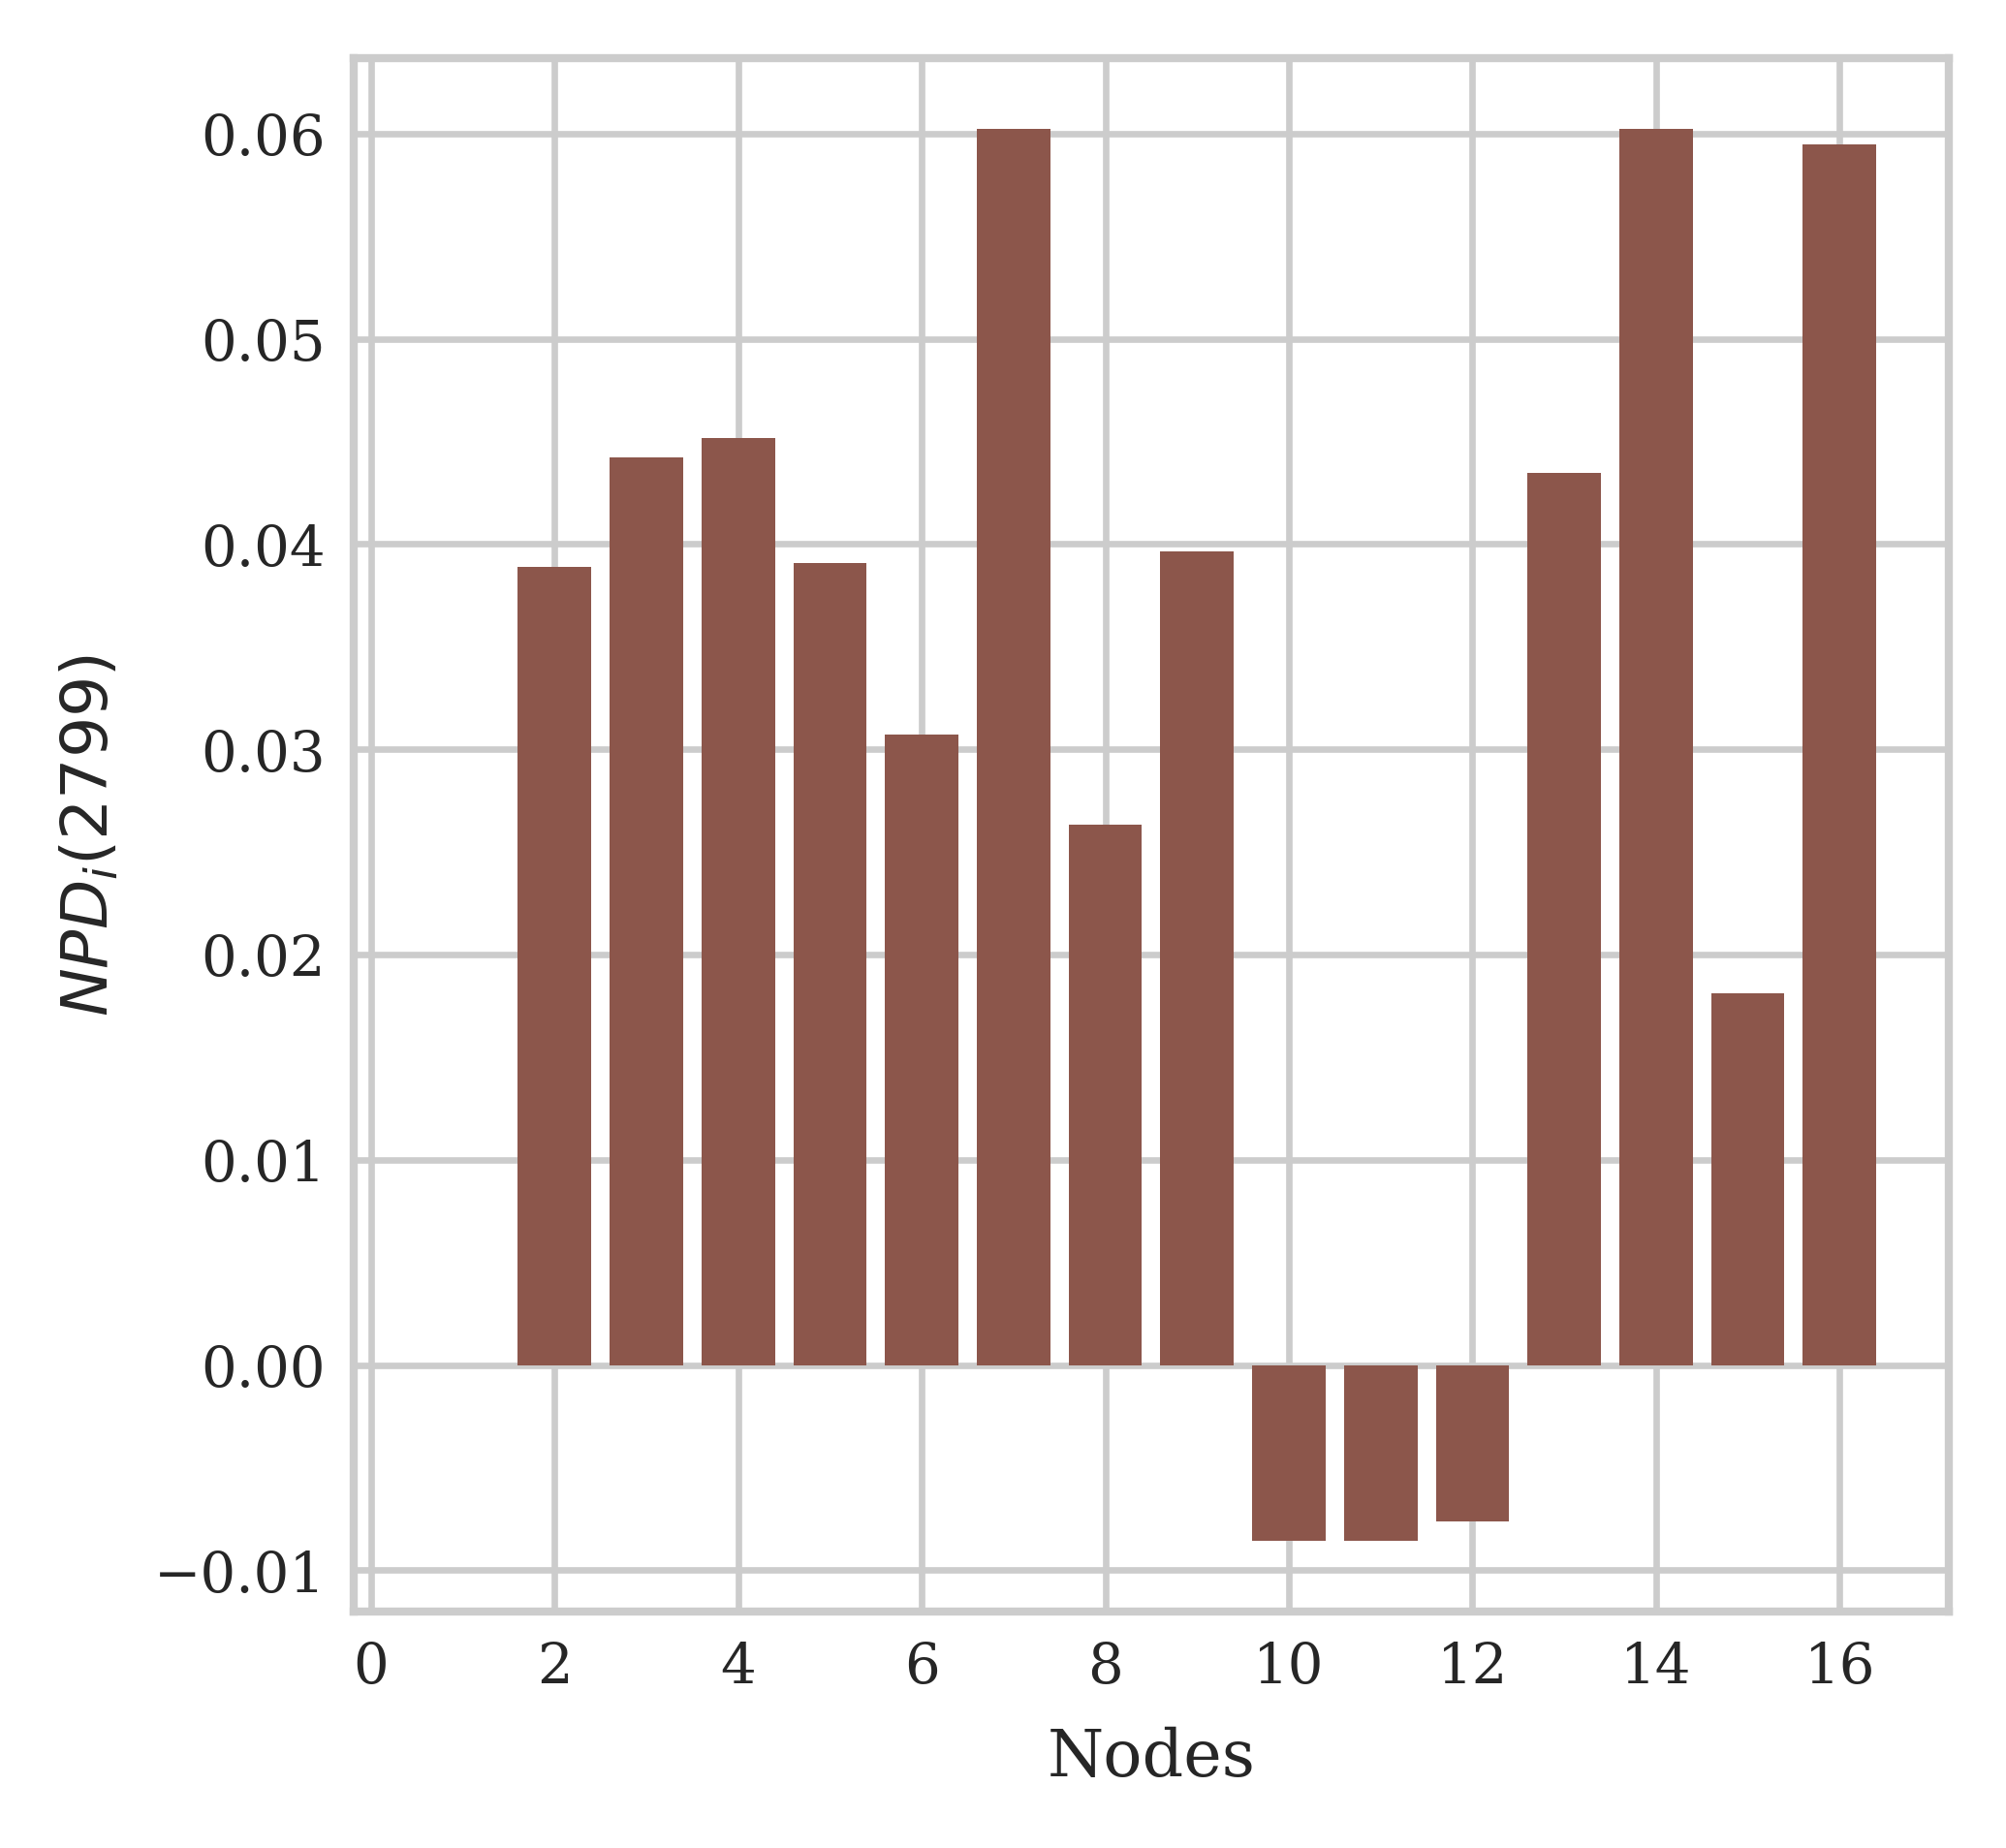

In [20]:
#Estmating NPD_i(2799)
norm_delay_anal=np.empty([N,1])

for node in range(N):
    norm_delay_anal[node]=(t_analytic[node,2799]-t_analytic[0,2799])/per_mean_analytic
    
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)
Nodelist=range(N)+np.ones(N)
for node in range(N):
    plt.bar(range(N)+np.ones(N),norm_delay_anal[:,0])
plt.xlabel('Nodes', fontsize=8)
plt.ylabel('$NPD_i(2799)$', fontsize=8)

mean_norm_delay_anal=np.mean(norm_delay_anal)
STD_norm_delay_anal=np.std(norm_delay_anal)
print('mean_norm_delay=', mean_norm_delay_anal)
print('STD_norm_delay=', STD_norm_delay_anal)

##### RUNNING THE ANALYTICAL CODE WITH SECOND ORDER FILTER

In [22]:
#Generate transmission pattern in 1 sec
TxPattern = np.random.randint(N,size=tt_analytical)
timeCNT=0   #Discrete-time index
number_superframes=1

#  Start simulation d
for Counter200 in range(number_superframes): # Counts frames of length 1 sec
        for frame_index in range(tt_analytical):
            timeCNT = timeCNT+1      #Current global time
            UserTxNow = TxPattern[frame_index]  #This is the tranmsitter which sends this time
            for UserIndex in range(N):         # update clocks of all nodes (using Eqn. (16))
                if timeCNT<= tt_analytical-1:
                    weight= np.dot(Adj_Matrix[UserIndex,:],TimeOfFlight_Matrix_analytic[:,UserIndex])+ np.dot(Adj_Matrix[UserIndex,:],(t_analytic[:,timeCNT-1]-t_analytic[UserIndex,timeCNT-1])) # when we consider propagation delay
                    if timeCNT==1:
                        delay=0.3*(np.dot(Adj_Matrix[UserIndex,:],TimeOfFlight_Matrix_analytic[:,UserIndex]))
                        t_analytic[UserIndex,timeCNT] = t_analytic[UserIndex,timeCNT-1] + Tnode[UserIndex] + Eps0*(weight+delay)
                    else:
                        delay= 0.3*(np.dot(Adj_Matrix[UserIndex,:],TimeOfFlight_Matrix_analytic[:,UserIndex])+ np.dot(Adj_Matrix[UserIndex,:],(t_analytic[:,timeCNT-2]-t_analytic[UserIndex,timeCNT-2]))) # when we consider propagation delay
                        t_analytic[UserIndex,timeCNT] = t_analytic[UserIndex,timeCNT-1] + Tnode[UserIndex] + Eps0*(weight+delay)
                   

period is 0.005002737
tensor(3.8234e-07)


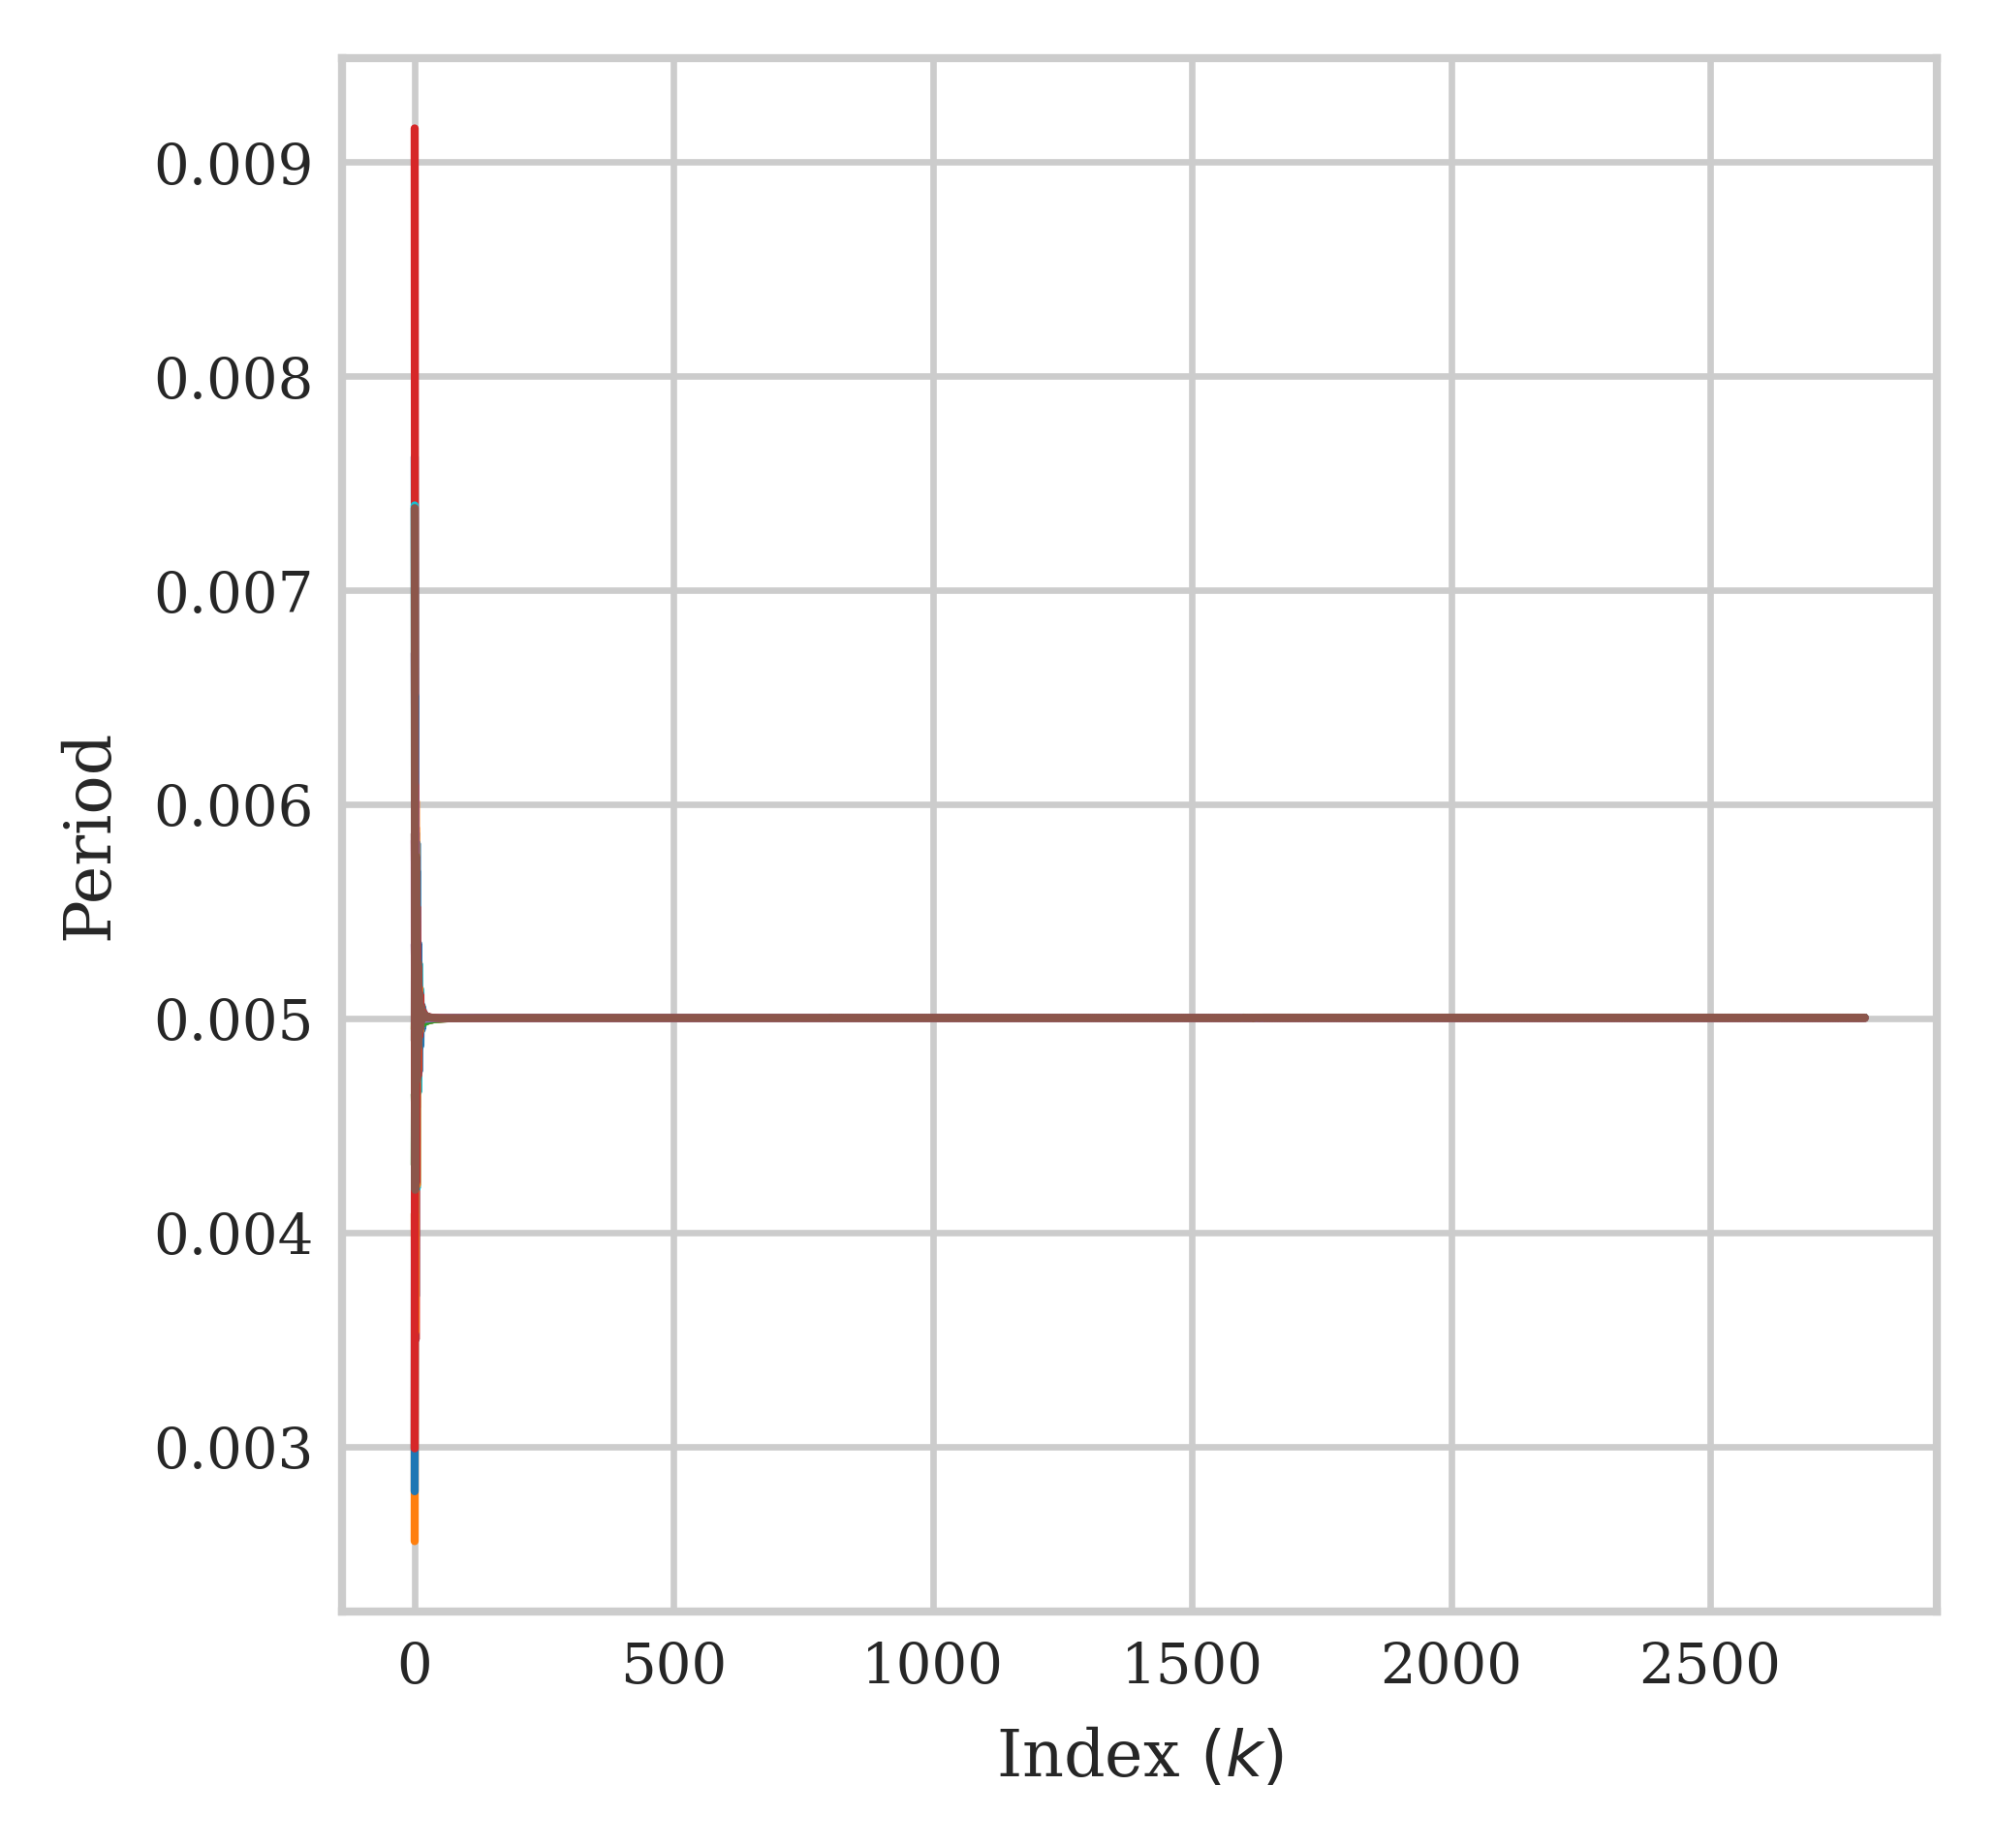

In [23]:
# PLOTTIN PERIOD ACROSS NODES
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)
period_analytic=torch.zeros(N,tt_analytical-1)
per_var_analytic=torch.zeros(tt_analytical-1)
per_mean_analytic=torch.zeros(tt_analytical-1)
for ind in range(tt_analytical-1):
    for i in range(N):
        period_analytic[i,ind]=t_analytic[i,ind+1]-t_analytic[i,ind]
    per_var_analytic[ind]=torch.var(period_analytic[:,ind])


for node in range(N):
    plt.plot(range(tt_analytical-1),(period_analytic[node,:]), linewidth=1)
plt.xlabel('Index $(k)$', fontsize=8)
plt.ylabel('Period', fontsize=8)

per_mean_analytic=torch.mean(period_analytic[:,tt_analytical-2])
print("period is", per_mean_analytic.detach().numpy())

#MEAN OF THE VARIANCE NORMALIZED TO THE CLOCK
mean_per_var_analytic=torch.mean(per_var_analytic)/Time_res
print(mean_per_var_analytic)

tensor([[1.7011e-04, 2.7907e-03, 3.2765e-03,  ..., 1.9181e-03, 1.9174e-03,
         1.9186e-03],
        [4.7212e-03, 2.2762e-03, 2.1179e-03,  ..., 2.1088e-03, 2.1081e-03,
         2.1083e-03],
        [4.4009e-03, 3.7141e-03, 3.6818e-03,  ..., 2.1346e-03, 2.1338e-03,
         2.1341e-03],
        ...,
        [3.4348e-03, 1.4231e-03, 2.5110e-03,  ..., 2.2156e-03, 2.2149e-03,
         2.2151e-03],
        [2.5662e-05, 1.7290e-03, 2.6934e-03,  ..., 2.0068e-03, 2.0070e-03,
         2.0063e-03],
        [8.7826e-04, 3.2597e-03, 2.4564e-03,  ..., 2.2118e-03, 2.2120e-03,
         2.2123e-03]], dtype=torch.float64)

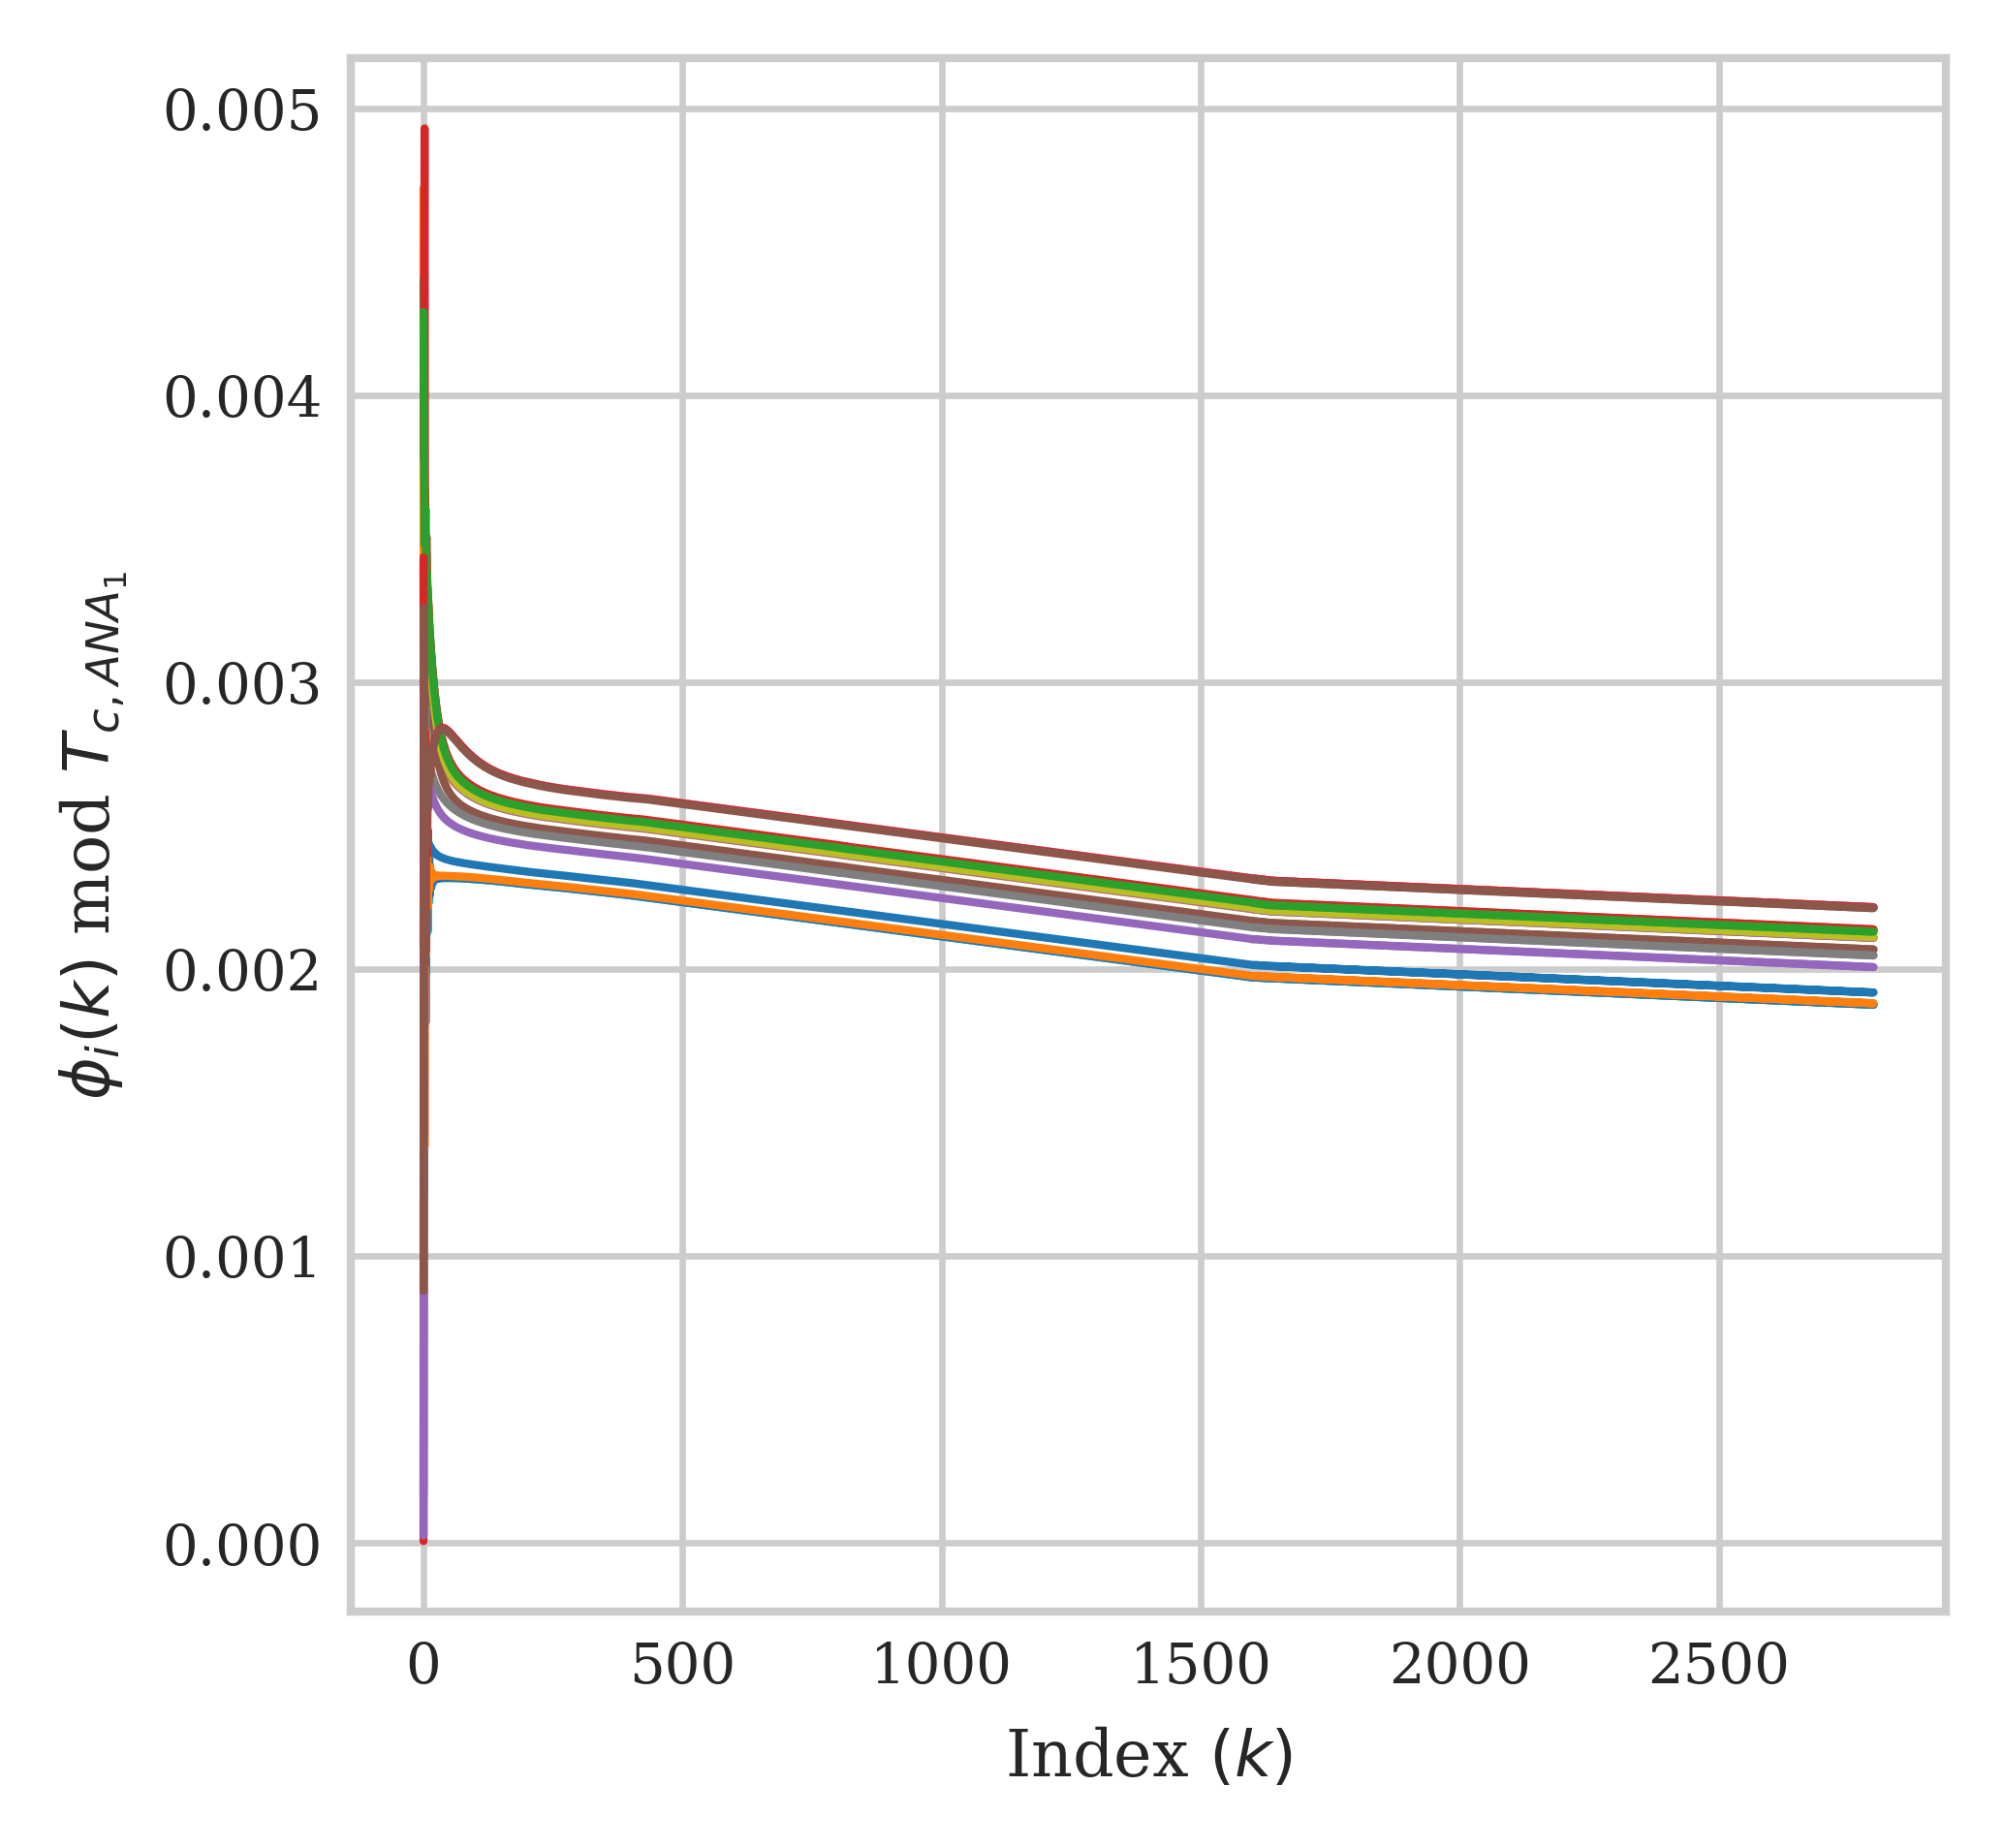

In [26]:
# PLOTTING MODULUS WRT PERIOD
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)
modulo_analytic=torch.tensor(t_analytic)%per_mean_analytic
for node in range(N):
    plt.plot(modulo_analytic[node,:], linewidth=1)
plt.xlabel('Index $(k)$', fontsize=8)
plt.ylabel('$\phi_i(k)$ mod $T_{c,ANA_1}$', fontsize=8)

modulo_analytic

Text(0, 0.5, '$\\phi_i(k)$ mod $T_c$')

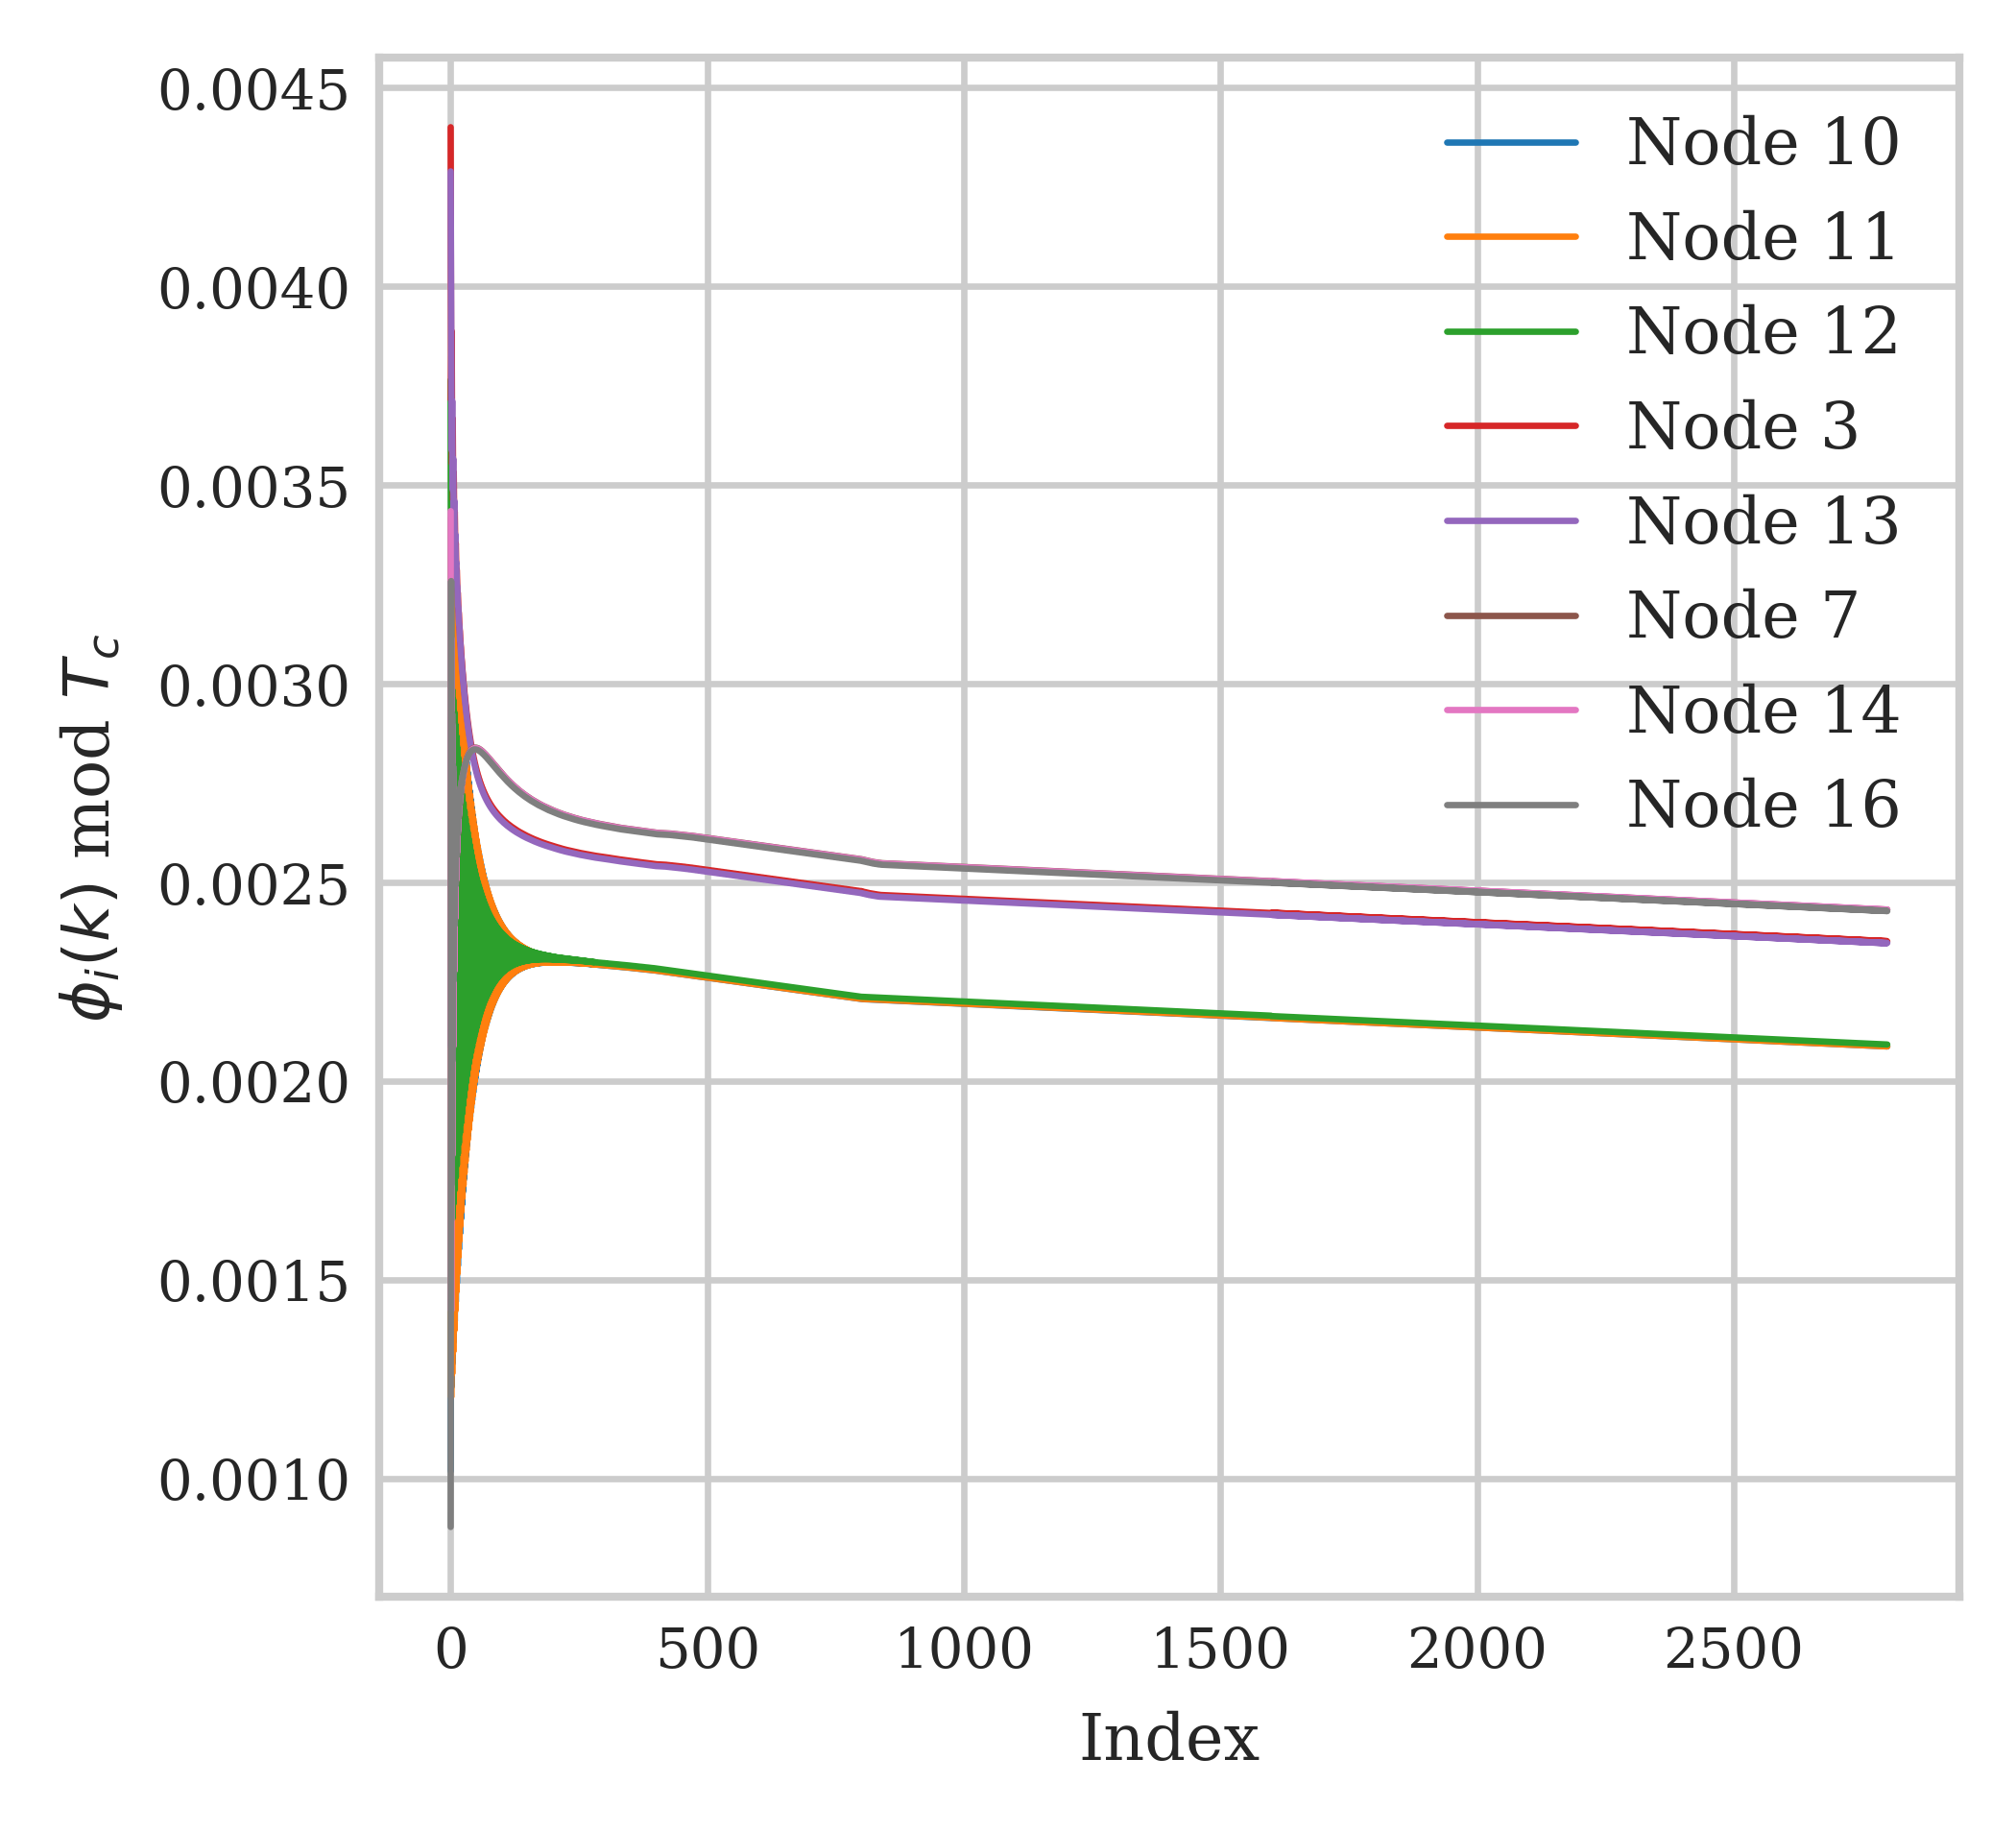

In [19]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)
plt.plot(range(tt_analytical),modulo_analytic[9,:], linewidth=0.8,label="Node 10")
plt.plot(range(tt_analytical),modulo_analytic[10,:], linewidth=0.8,label="Node 11")
plt.plot(range(tt_analytical),modulo_analytic[11,:], linewidth=0.8,label="Node 12")
plt.plot(range(tt_analytical),modulo_analytic[2,:], linewidth=0.8,label="Node 3")
plt.plot(range(tt_analytical),modulo_analytic[12,:], linewidth=0.8,label="Node 13")
plt.plot(range(tt_analytical),modulo_analytic[6,:], linewidth=0.8,label="Node 7")
plt.plot(range(tt_analytical),modulo_analytic[13,:], linewidth=0.8,label="Node 14")
plt.plot(range(tt_analytical),modulo_analytic[15,:], linewidth=0.8,label="Node 16")

plt.legend(loc="upper right",fontsize='8')
plt.xlabel('Index',fontsize='8')
plt.ylabel('$\phi_i(k)$ mod $T_c$',fontsize='8')

mean_norm_delay= 0.030052073241677135
STD_norm_delay= 0.02373870324643376


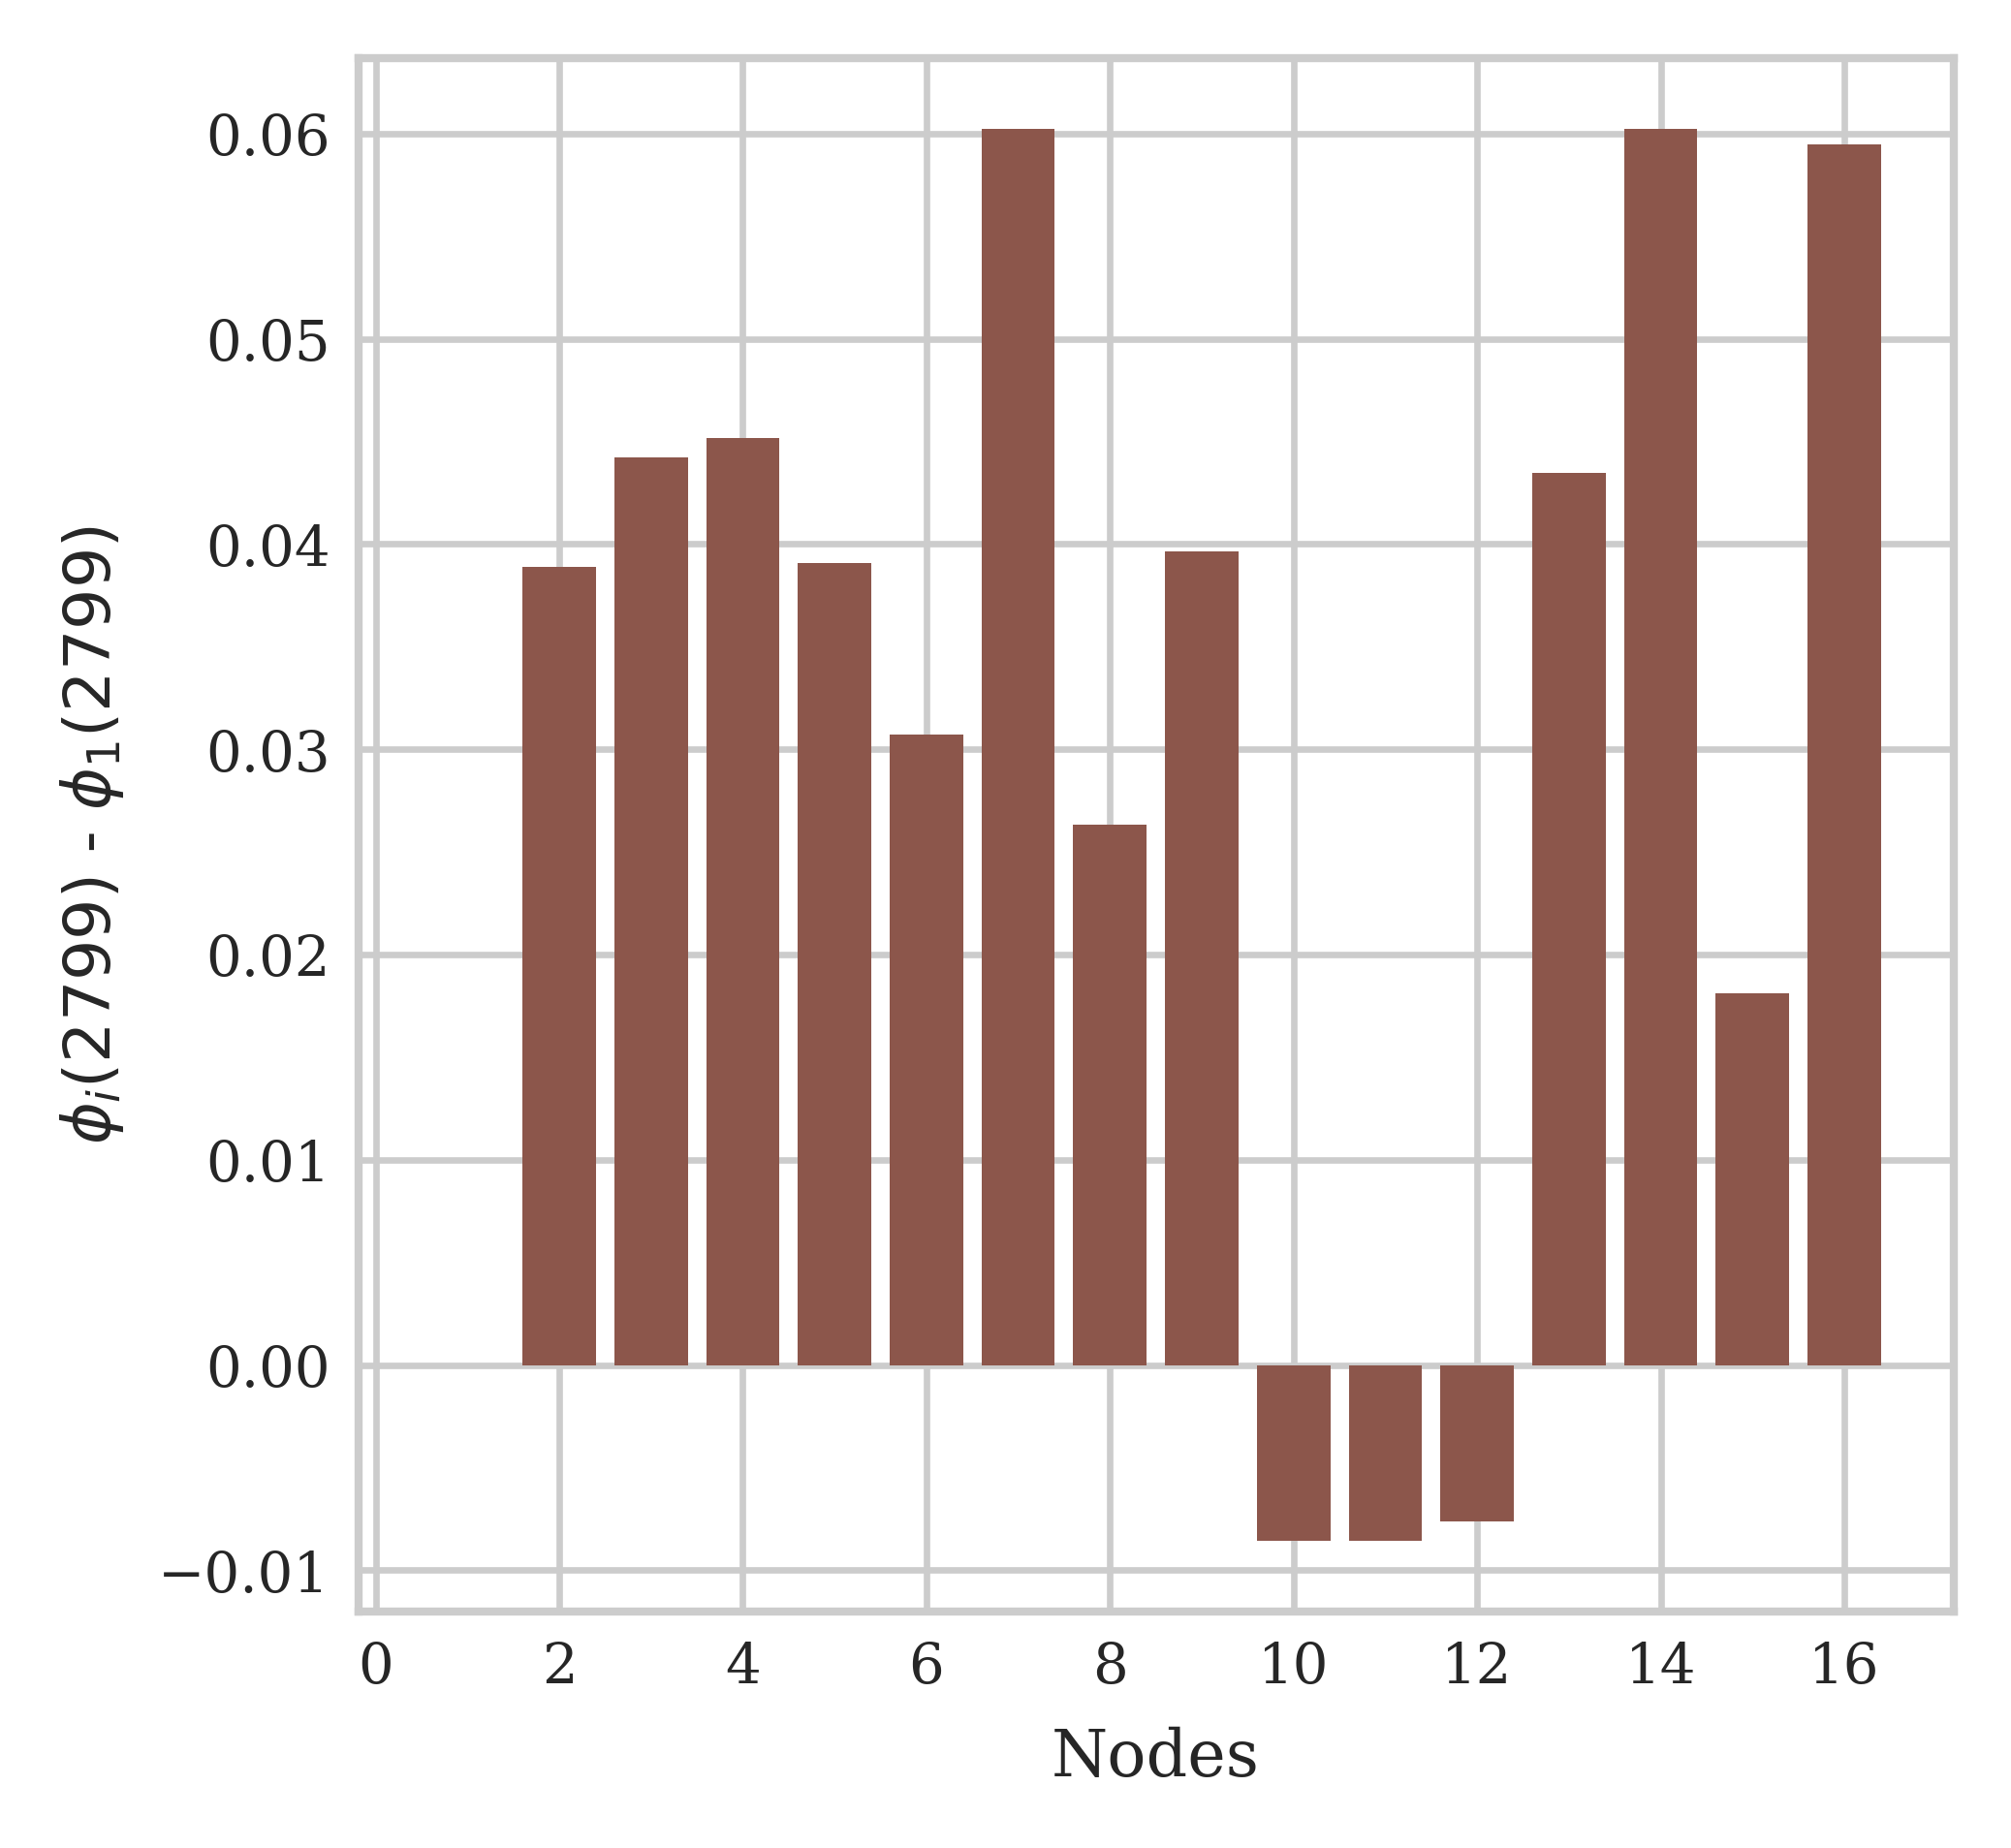

In [20]:

#Estmating NPD_i(2799)
norm_delay_anal=np.empty([N,1])

for node in range(N):
    norm_delay_anal[node]=(t_analytic[node,2799]-t_analytic[0,2799])/per_mean_analytic
    
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)
Nodelist=range(N)+np.ones(N)
for node in range(N):
    plt.bar(range(N)+np.ones(N),norm_delay_anal[:,0])
plt.xlabel('Nodes', fontsize=8)
plt.ylabel('$\phi_i(2799)$ - $\phi_1(2799)$', fontsize=8)

mean_norm_delay_anal=np.mean(norm_delay_anal)
STD_norm_delay_anal=np.std(norm_delay_anal)
print('mean_norm_delay=', mean_norm_delay_anal)
print('STD_norm_delay=', STD_norm_delay_anal)

### INTRODUCING FREQUENT CLOCK PHASE AND PERIOD RESET FOR SOME NODES

In [ ]:
#Generate transmission pattern in 1 sec
TxPattern = np.random.randint(N,size=tt_analytical)
timeCNT=0   #Discrete-time index
SncPer=280
Sncbatch=int((tt_analytical)/SncPer)
#  Start simulation d

for Pcnt in range(Sncbatch):
    for frame_index in range(Pcnt*SncPer,Pcnt*SncPer+SncPer):
        timeCNT = timeCNT+1      #Current global time
        UserTxNow = TxPattern[frame_index]  #This is the tranmsitter which sends this time
        for UserIndex in range(N):         # update clocks of all nodes (using Eqn. (16))
            if timeCNT<= tt_analytical-1:
                weight= np.dot(Adj_Matrix[UserIndex,:],TimeOfFlight_Matrix_analytic[:,UserIndex])+ np.dot(Adj_Matrix[UserIndex,:],(t_analytic[:,timeCNT-1]-t_analytic[UserIndex,timeCNT-1])) # when we consider propagation delay
                t_analytic[UserIndex,timeCNT] = t_analytic[UserIndex,timeCNT-1] + Tnode[UserIndex] + Eps0*weight
                if timeCNT==Pcnt*SncPer+SncPer:
                    missclk=random.sample(range(N),5) #randly select some clocks which lose synchrony at the begining of each sncbatch.
                    #RESETTING THE INDIVIDUAL Ti FOR SELCTED NODES
                    a=1/(10**(torch.FloatTensor(len(missclk), 1).uniform_(4, 6)))
                    b=torch.FloatTensor(len(missclk),1).uniform_(-1,1)
                    for ind in range(len(missclk)):
                        if b[ind]<0:
                            b[ind]=-1
                        else:
                            b[ind]=1
                    cnt=0   
                    for clk in missclk:
                        Tnode[clk]=Time_res*(1+b[cnt]*a[cnt])
                        t_analytic[clk,timeCNT]=t_analytic[clk,timeCNT]+ Tnode[clk]*np.random.rand(1,1)
                        cnt+=1

In [ ]:
# PLOTTING THE PERIOD
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)
period_analytic=torch.zeros(N,tt_analytical-1)
per_var_analytic=torch.zeros(tt_analytical-1)
per_mean_analytic=torch.zeros(tt_analytical-1)
for ind in range(tt_analytical-1):
    for i in range(N):
        period_analytic[i,ind]=t_analytic[i,ind+1]-t_analytic[i,ind]
    per_var_analytic[ind]=torch.var(period_analytic[:,ind])


for node in range(N):
    plt.plot(range(tt_analytical-1),(period_analytic[node,:]), linewidth=1)
plt.xlabel('Index  $(k)$', fontsize=8)
plt.ylabel('Period', fontsize=8)


per_mean_analytic=torch.mean(period_analytic[:,tt_analytical-2])
print("period is", per_mean_analytic.detach().numpy())

#MEAN OF THE VARIANCE NORMALIZED TO THE CLOCK
mean_per_var_analytic=torch.mean(per_var_analytic)/Time_res
print(mean_per_var_analytic)

In [ ]:
# PLOTTING THE MODULUS 
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)
modulo_analytic=torch.tensor(t_analytic)%per_mean_analytic
for node in range(N):
    plt.plot(modulo_analytic[node,:], linewidth=1)
plt.xlabel('Index  $(k)$', fontsize=8)
plt.ylabel('$\phi_i(k)$ mod $T_{c,ANA}$', fontsize=8)
